In [348]:
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import time 

In [349]:
# load data 
mbd_data = pd.read_csv('./outputs/mbd_data.csv')
clusters = json.loads(open('./outputs/clusters_sarimax.json',"r").read())
cluster_keys = ["0","1","2","3","4","5","6","-1"]
mbd_data = mbd_data.sort_values(by=["cfips","first_day_of_month"]).reset_index(drop=True)
mbd_data.median_hh_inc.ffill(inplace=True)
mbd_data.pct_it_workers.ffill(inplace=True)

sc = MinMaxScaler()
mbd_data.median_hh_inc = sc.fit_transform( mbd_data.median_hh_inc.values.reshape(-1,1) ).reshape(-1)

cfips = mbd_data.cfips.unique()

In [350]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_pred) + np.abs(y_true)) / 2
    smape_val = np.mean(numerator / denominator)
    return smape_val

In [351]:
# Plot a county 

def plot_county(cfip):
#     cfip = clusters["-1"][0]
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))
    dates = pd.date_range(start='2019-08-01', end='2022-12-01', freq='MS')
    values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

    # Plot the line
    ax.plot(dates, values)

    # Set the axis labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Microbusiness Density')
    ax.set_title(f'{location} ( CFIP {cfip} )  ')

    # Rotate the x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Show the plot
    plt.show()

In [352]:
cfip = int(list(clusters["0"].keys())[1])
int(cfip) in mbd_data.cfips

True

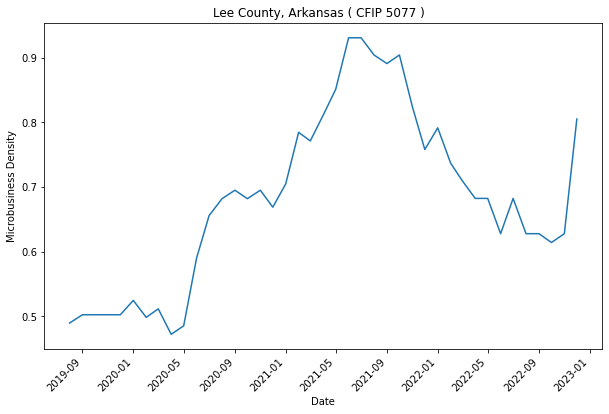

In [353]:
plot_county(cfip) 

In [354]:
def time_series_split(arr, k):
    n = len(arr)
    if k > n:
        return []
    window = [list(arr[i:i+k]) for i in range(n-k+1)]
    return np.array(window)

In [355]:
def train_xgboost_model(cfip, k,lr,depth,estimators,min_train_smape=np.inf, min_test_smape=np.inf,min_train_rmse=np.inf, min_test_rmse=np.inf, best_params=None, return_preds=False):
    data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
    data = time_series_split(data,k)
    
    train_size = int(0.9*len(data))
    X_train, X_test, y_train, y_test = data[:train_size,:-1],data[train_size:,:-1] , data[:train_size,-1:], data[train_size:,-1:]
    
    # Define the XGBoost model
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', # Regression task
        learning_rate=lr, # Learning rate
        max_depth=depth, # Maximum depth of the tree
        n_estimators=estimators # Number of trees
    )
    # Train the XGBoost model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the  test data
    y_test_pred = xgb_model.predict(X_test)
    cur_smape = smape(y_test_pred,y_test)
    if cur_smape < min_test_smape : 
        min_test_smape = cur_smape 
        y_train_pred = xgb_model.predict(X_train)

        min_train_smape = smape(y_train,y_train_pred)
        min_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        min_test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))
        best_params = {
            "k": k,
            "lr": lr,
            "min_depth": depth, 
            "n_estimators": estimators
        }     
    if return_preds: 
        return y_train, y_train_pred, y_test, y_test_pred
    return min_train_smape, min_test_smape, min_train_rmse, min_test_rmse, best_params

In [356]:
results = json.load(open("./outputs/xgboost_params.json","r"))

In [357]:
cfips_avail = [(cluster_id,cfip,results[cluster_id][cfip]["val_smape"],results[cluster_id][cfip]["best_params"]) for cluster_id in results for cfip in results[cluster_id]]
cfips_avail = sorted(cfips_avail, key=lambda x : -x[2])
cluster_id, cfip, val_smape,best_params = cfips_avail[0]
val_smape

1.334435694888498

In [358]:
avg = 0 
for i in range(len(cfips_avail)):
    avg += cfips_avail[i][2]
avg/len(cfips_avail)
# (0.09*len(cfips_avail) + 0.015*(3135-len(cfips_avail)))/3135

0.0875805662303633

In [359]:
k = best_params["k"]
# k = 4
cfip = int(cfip)
data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"]
data = time_series_split(data,k)
time_col = np.arange(0,len(data))
data  = np.insert(data,0,time_col,axis=1)

In [360]:
train_size = int(0.96*len(data))
X_train, X_test, y_train, y_test = data[:train_size,:-1],data[train_size:,:-1] , data[:train_size,-1:], data[train_size:,-1:]

In [361]:
X_train.shape, y_test.shape

((28, 12), (2, 1))

In [362]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Regression task
    learning_rate=best_params["lr"], # Learning rate
    max_depth=best_params["min_depth"], # Maximum depth of the tree
    n_estimators=best_params["n_estimators"]# Number of trees
)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)


val_smape = smape(y_test_pred,y_test)
val_smape

1.0044729066668925

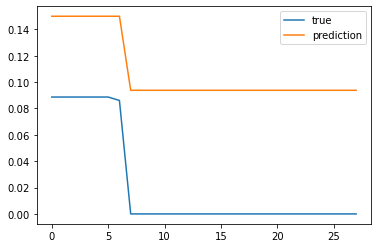

In [363]:
plt.plot(y_train,label='true')
plt.plot(y_train_pred,label='prediction')
plt.legend()
plt.show()

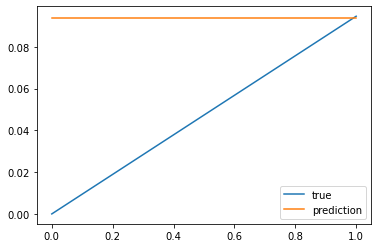

In [364]:
plt.plot(y_test,label='true')
plt.plot(y_test_pred,label='prediction')
plt.legend()
plt.show()

In [365]:
def calculate_error(cfip,best_params):
    k = best_params["k"]
    cfip = int(cfip)
    data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"]
    data = time_series_split(data,k)
    train_size = int(0.9*len(data))
    X_train, X_test, y_train, y_test = data[:train_size,:-1],data[train_size:,:-1] , data[:train_size,-1:], data[train_size:,-1:]
    # Define the XGBoost model
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', # Regression task
        learning_rate=best_params["lr"], # Learning rate
        max_depth=best_params["min_depth"], # Maximum depth of the tree
        n_estimators=best_params["n_estimators"]# Number of trees
    )

    # Train the XGBoost model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test)
    
    val_smape = smape(y_test_pred,y_test)
    return { "smape": val_smape, 
            "true":np.concatenate([y_train,y_test]).reshape(-1),
            "prediction":np.concatenate([y_train_pred,y_test_pred]).reshape(-1)
           }


In [366]:
len(results["-1"])

26

In [367]:
cfips_avail = [(cluster_id,cfip,results[cluster_id][cfip]["val_smape"],results[cluster_id][cfip]["best_params"]) for cluster_id in results for cfip in results[cluster_id]]
cfips_avail = sorted(cfips_avail, key=lambda x : -x[2])
results2 = {}
for cluster_id, cfip, val_smape,best_params in cfips_avail:
    results2[cfip] = calculate_error(cfip, best_params)

In [368]:
# cfip = cfips_avail[9][1]
cfip = '8033'


In [369]:
len(dates), len(results2[cfip]["true"])

(30, 38)

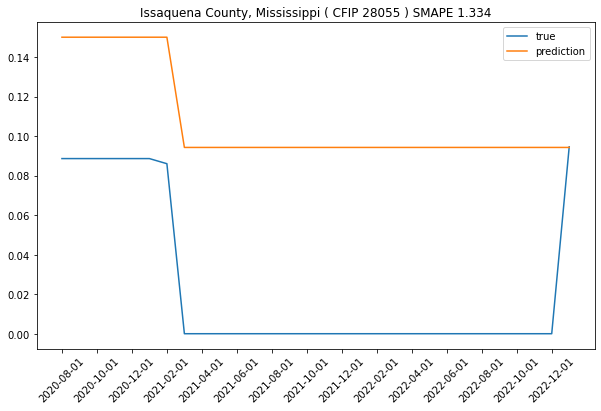

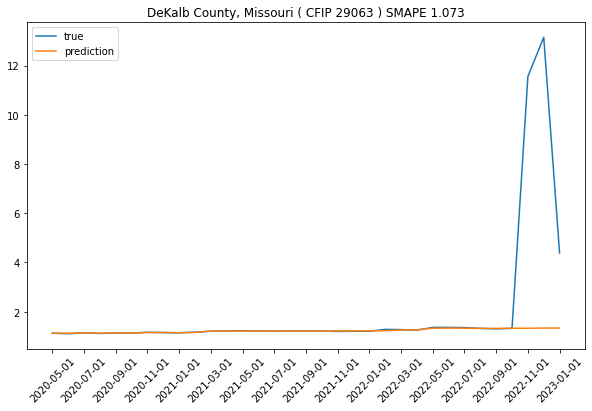

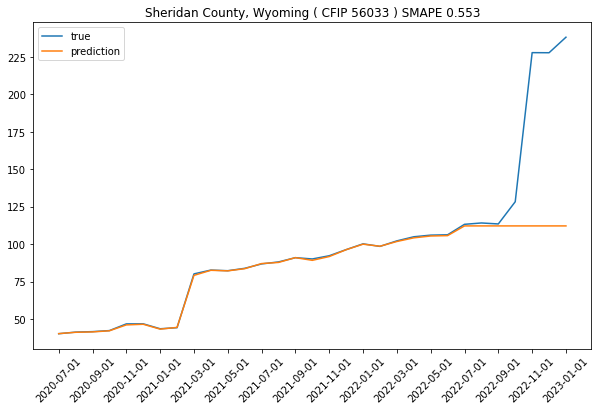

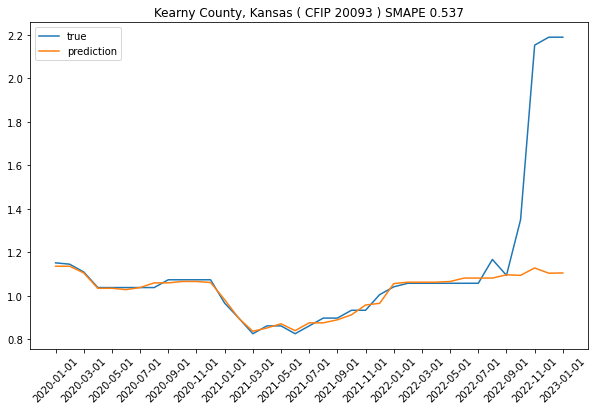

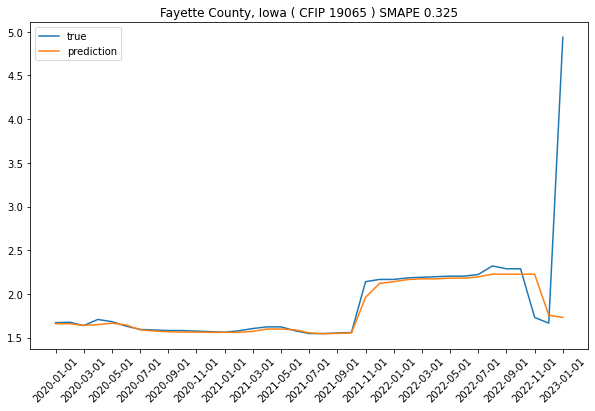

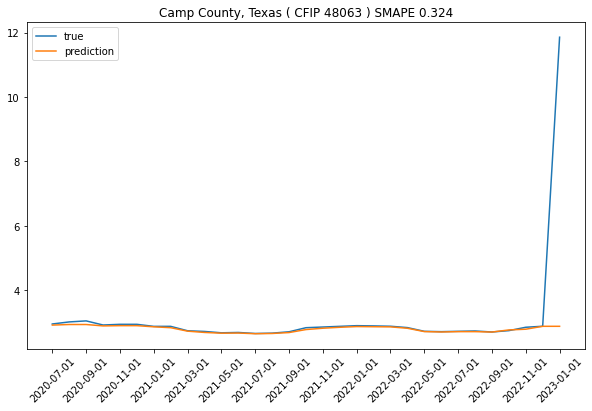

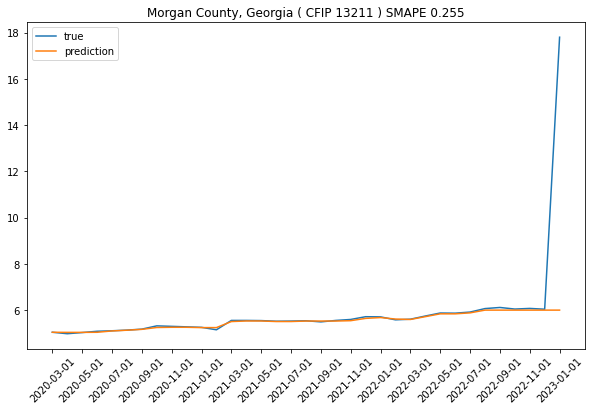

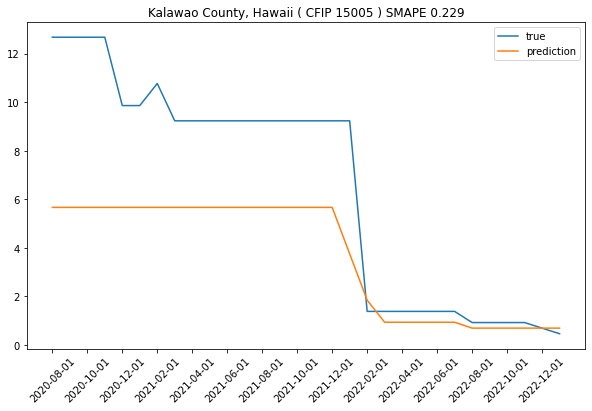

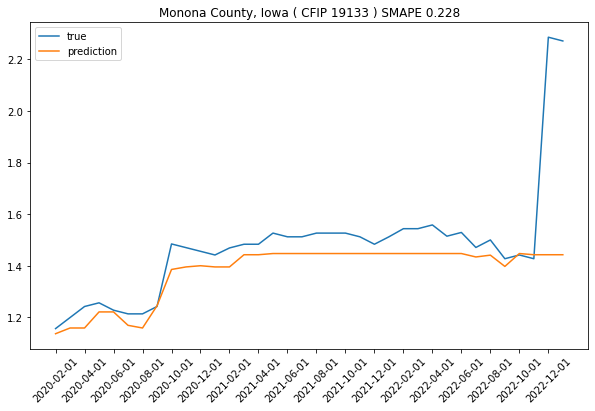

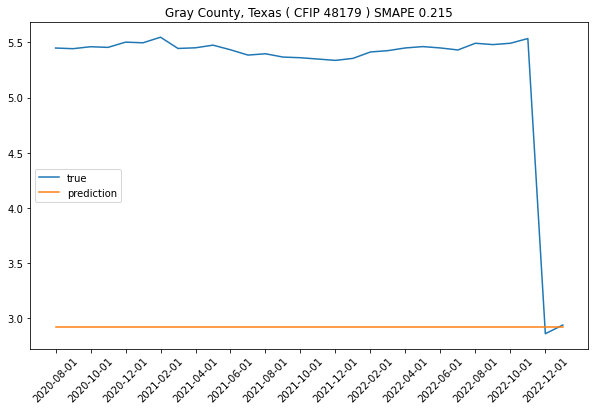

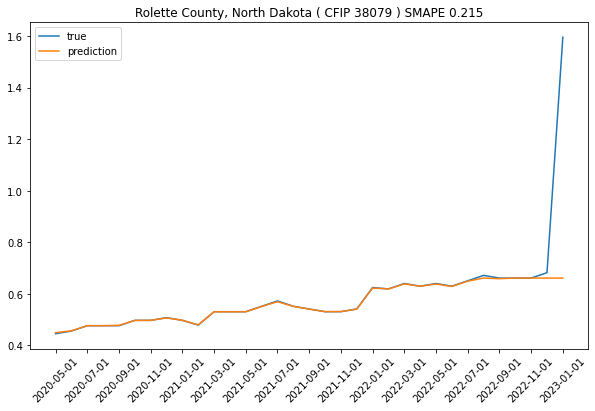

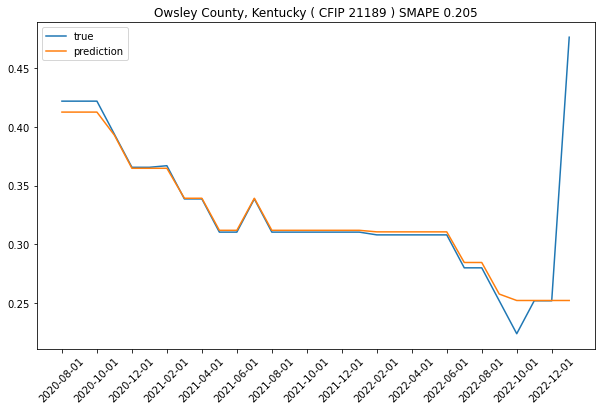

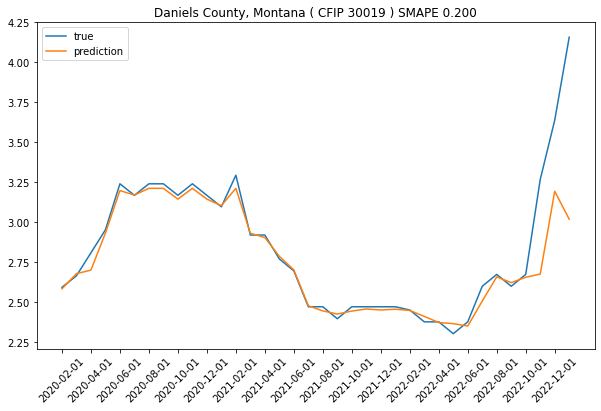

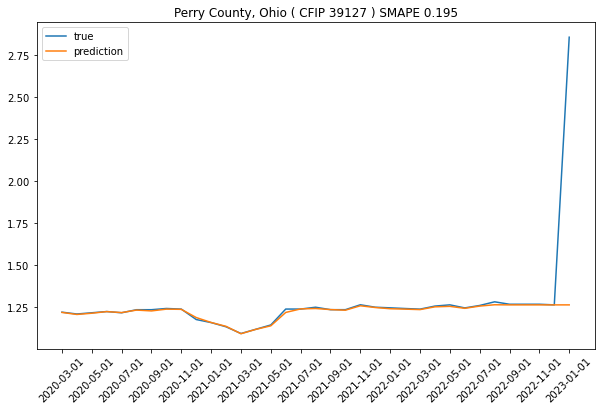

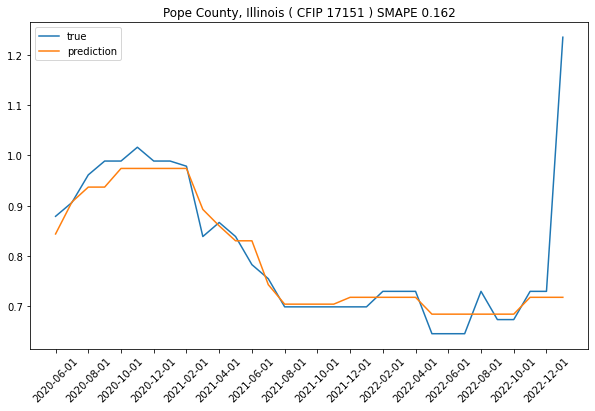

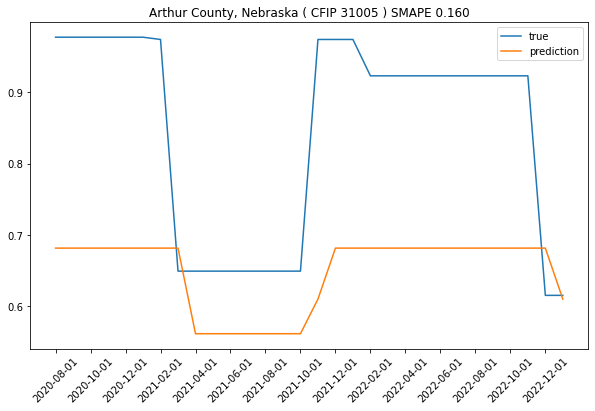

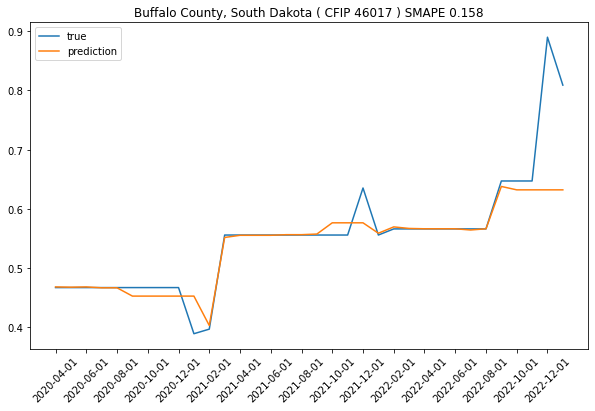

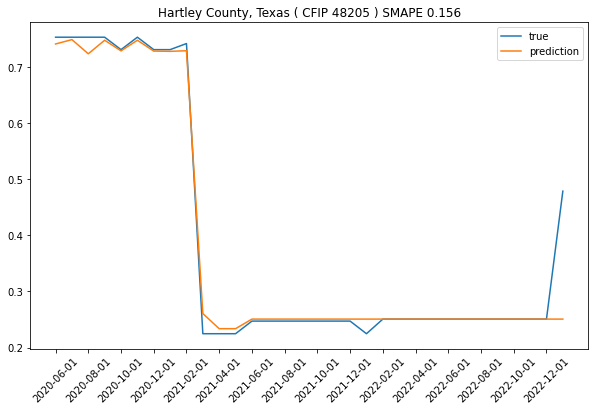

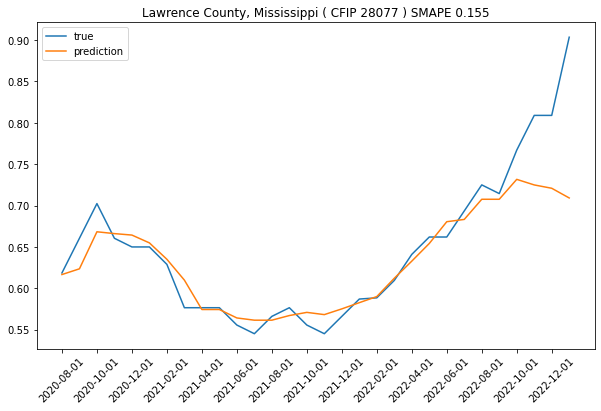

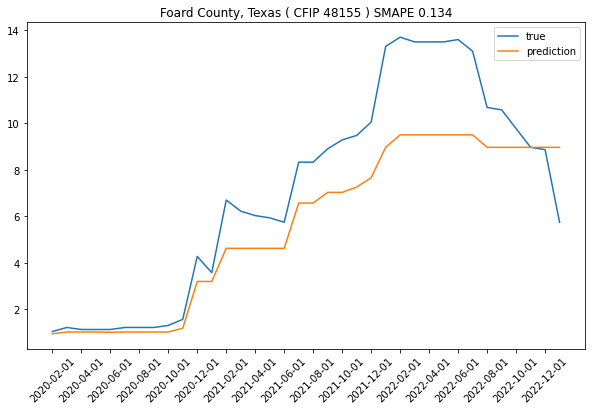

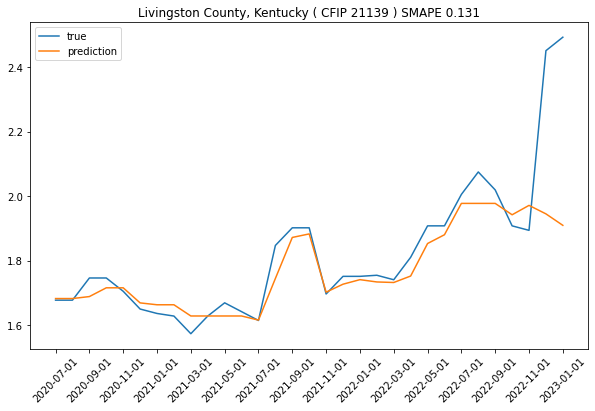

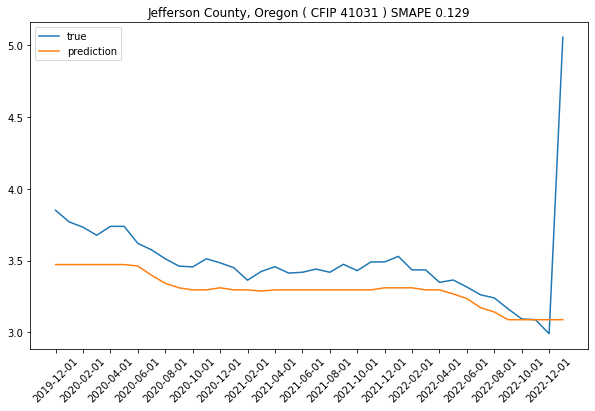

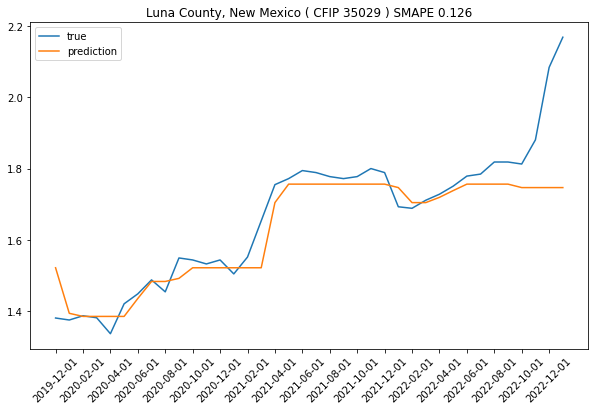

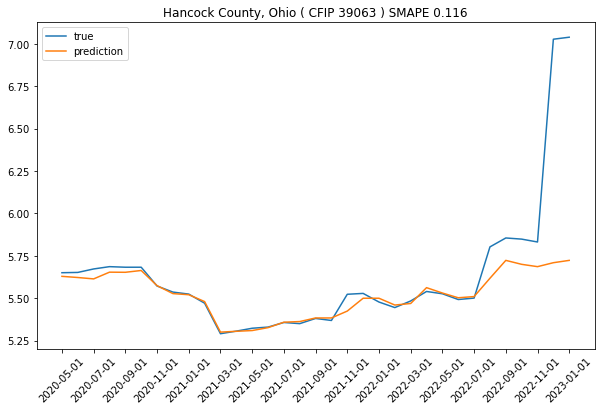

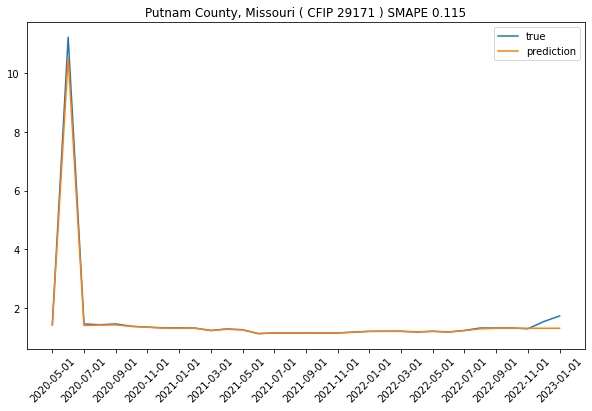

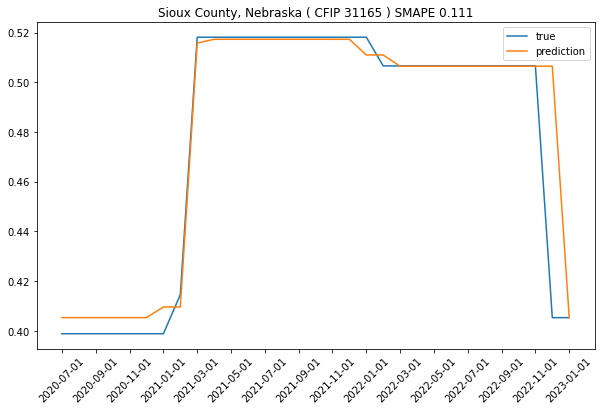

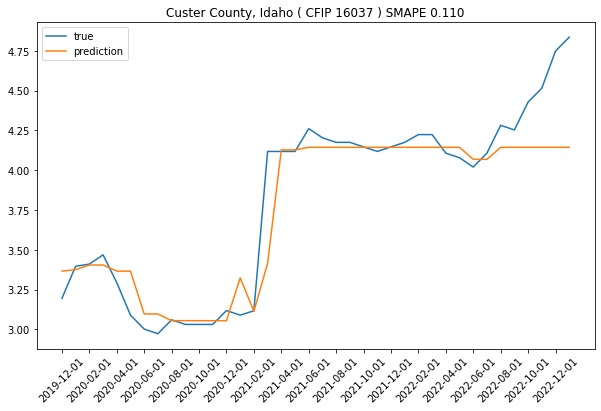

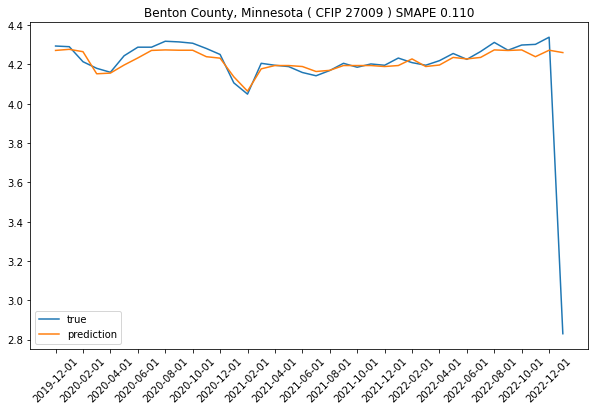

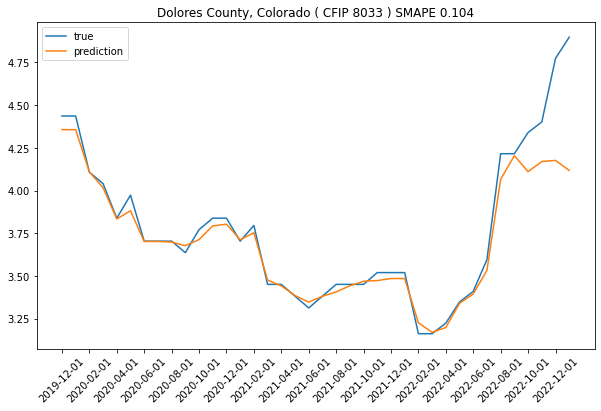

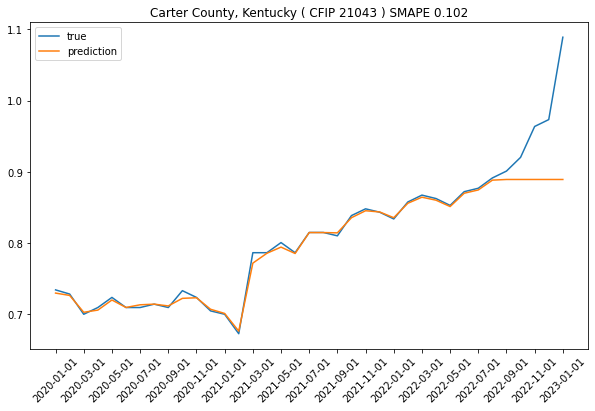

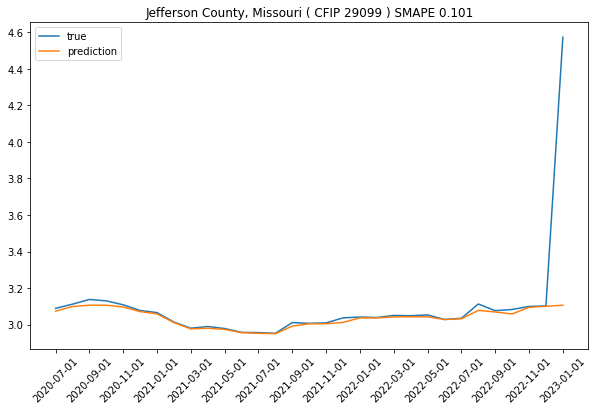

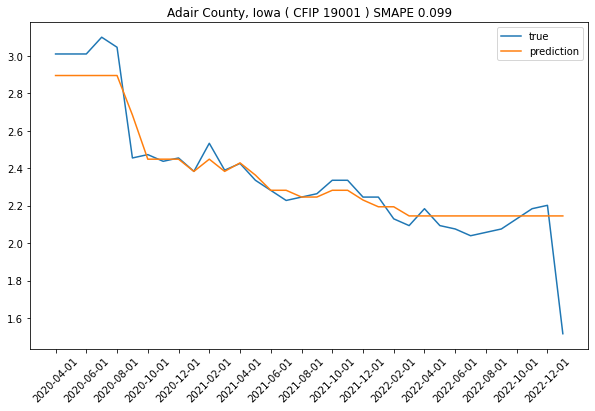

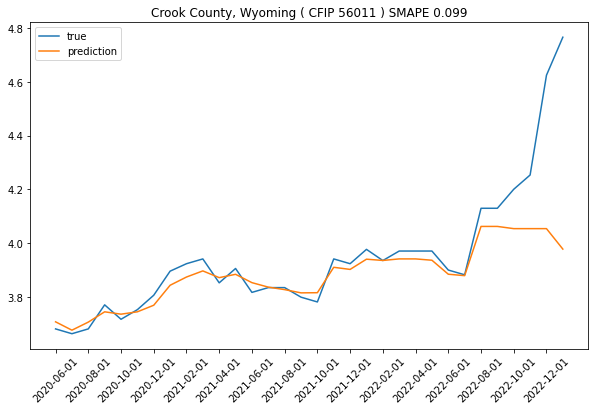

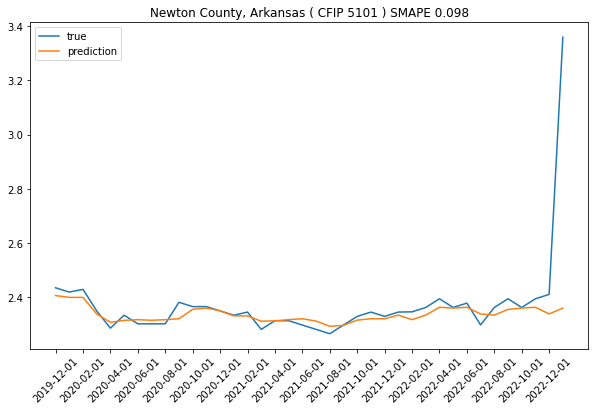

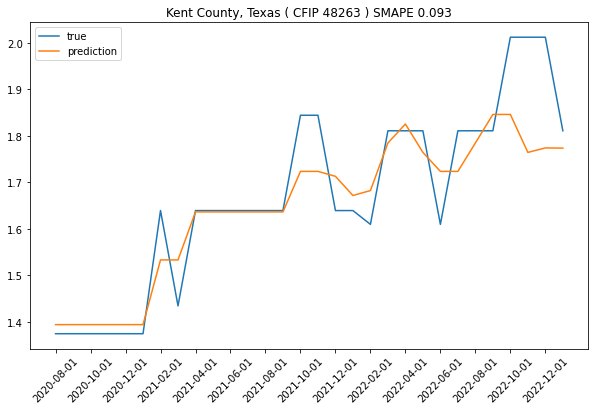

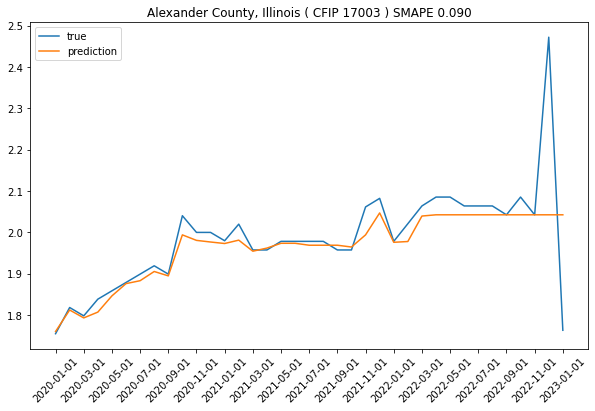

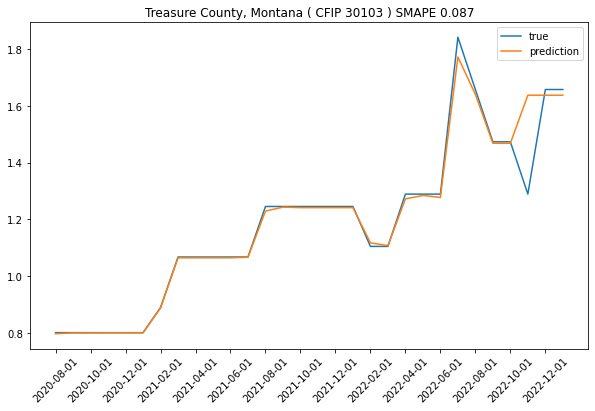

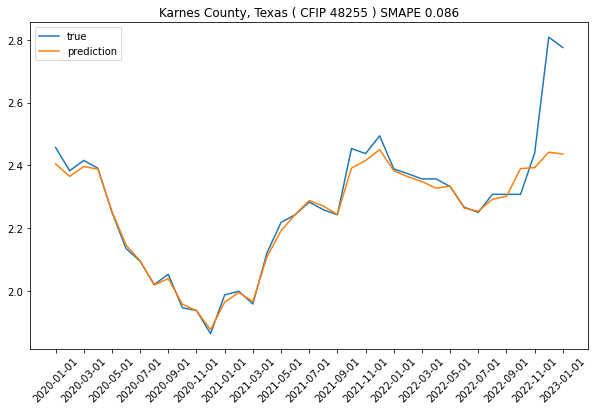

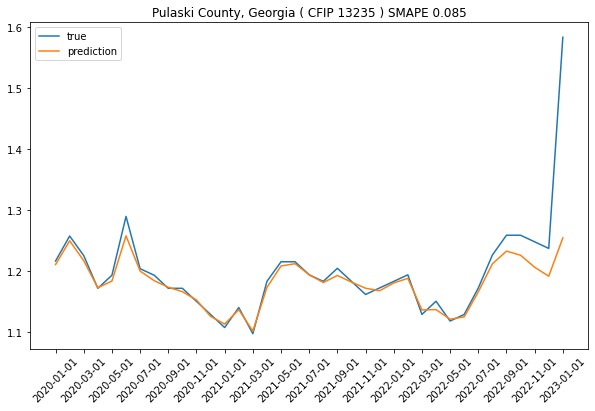

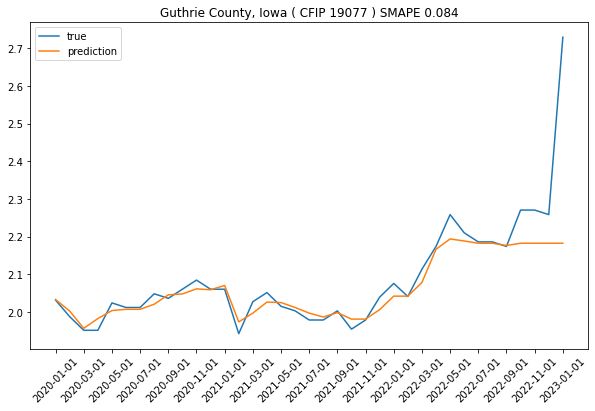

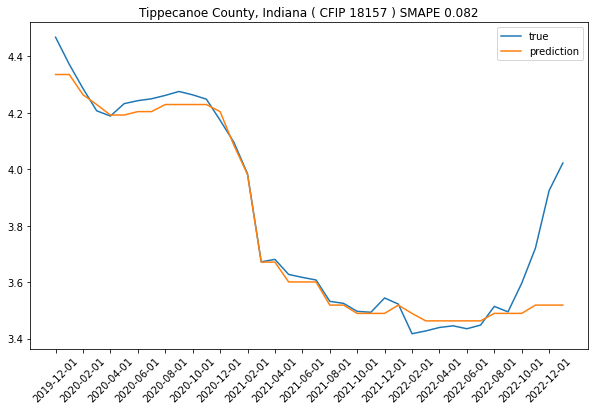

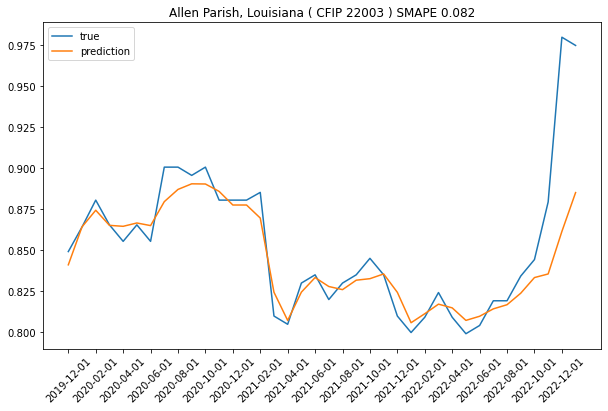

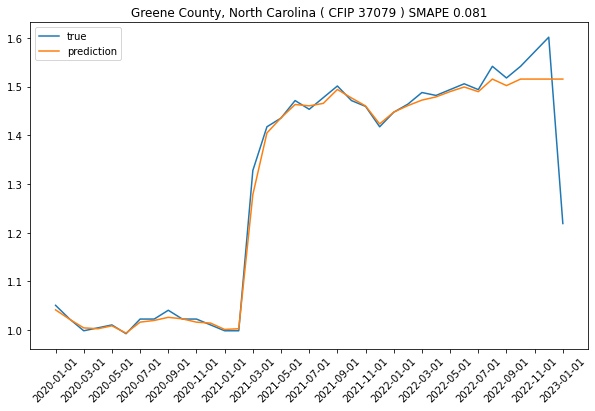

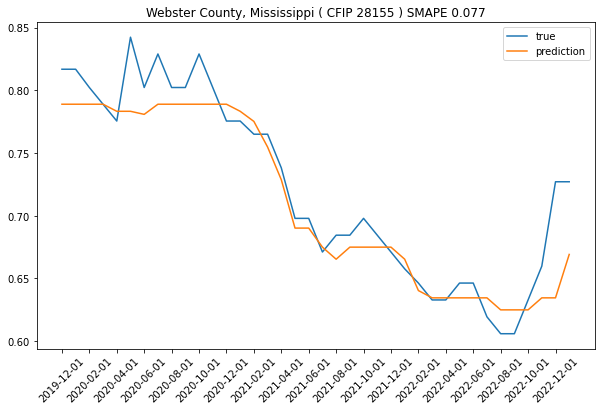

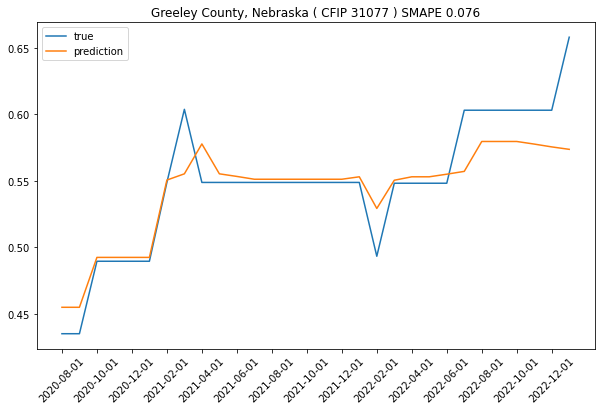

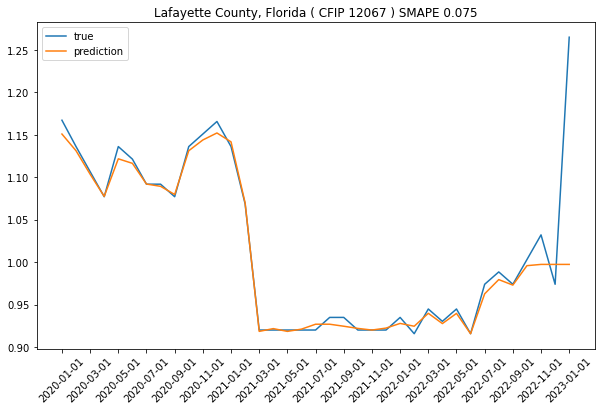

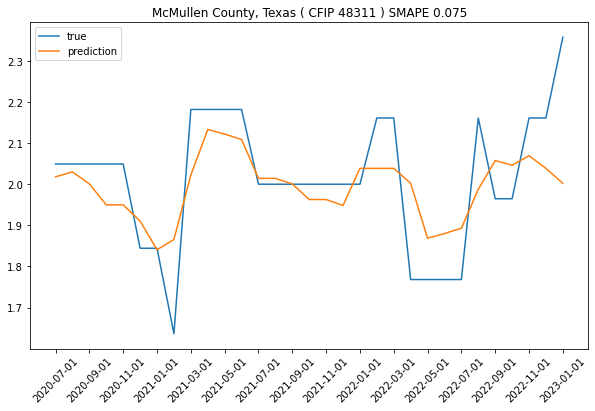

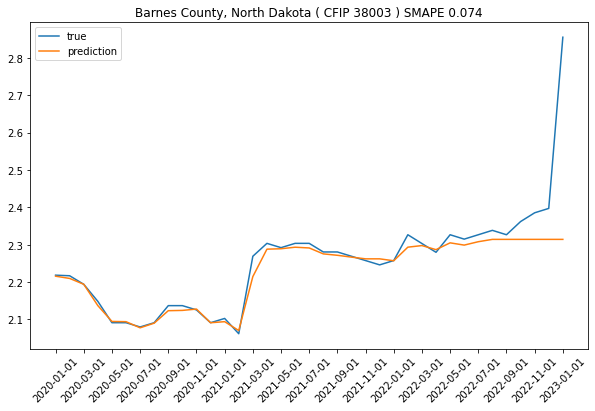

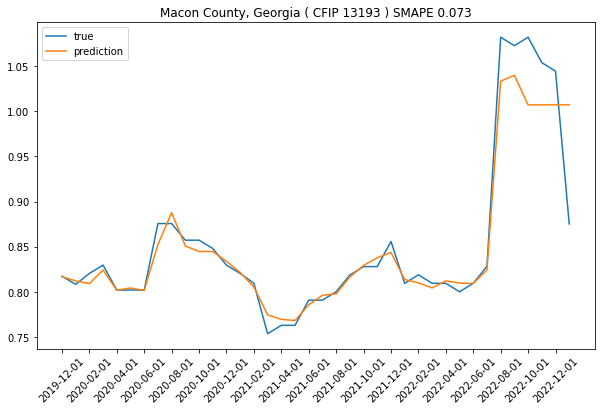

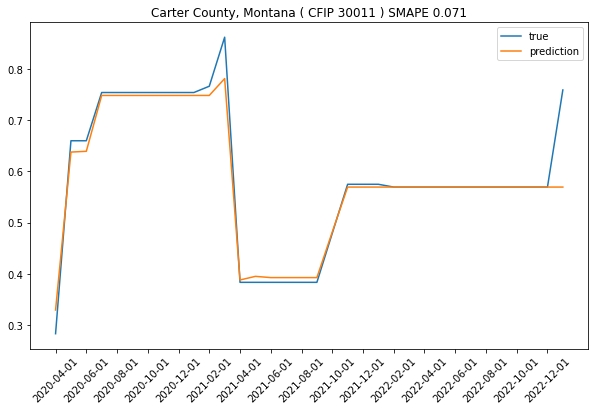

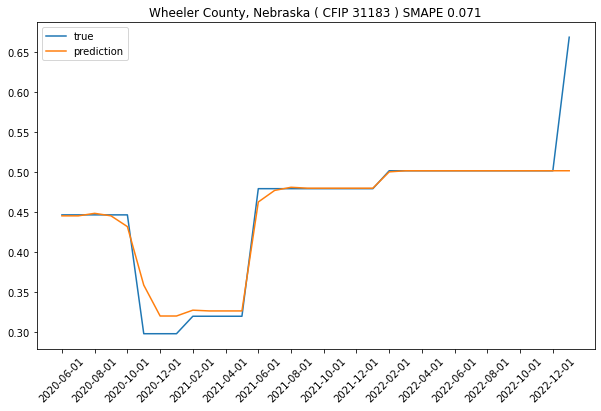

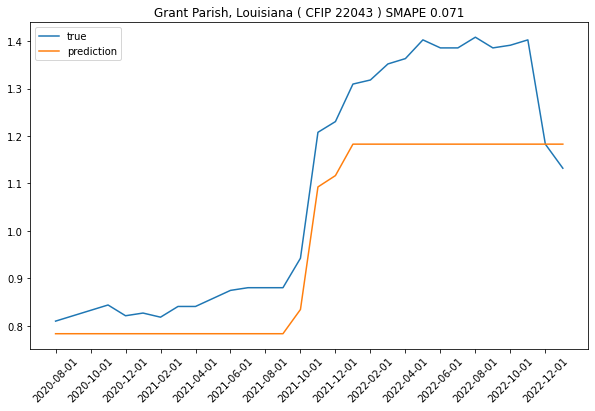

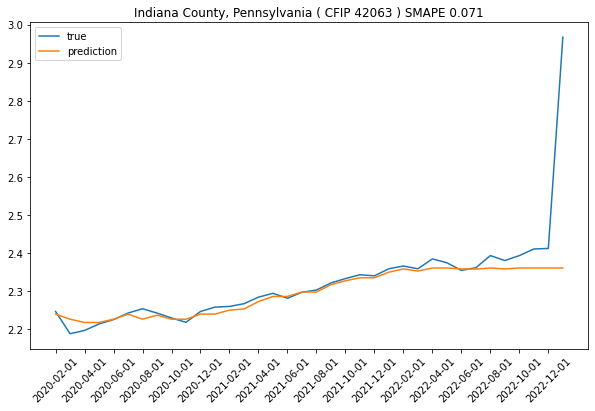

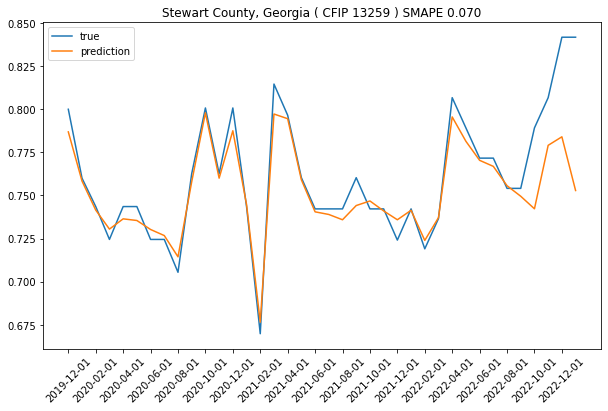

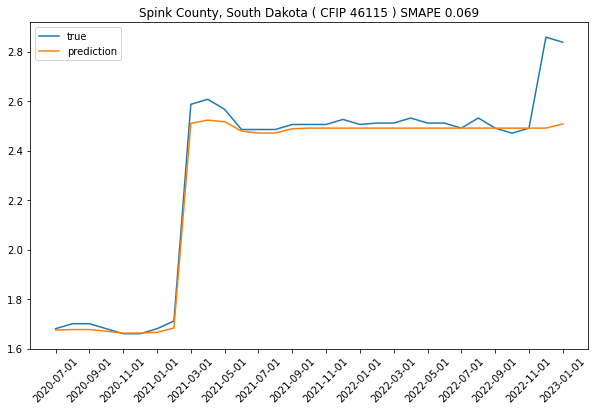

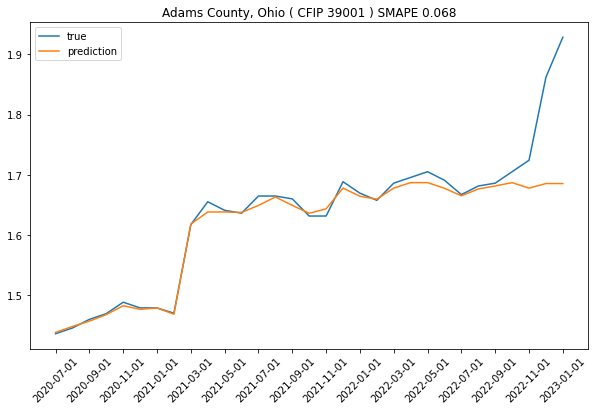

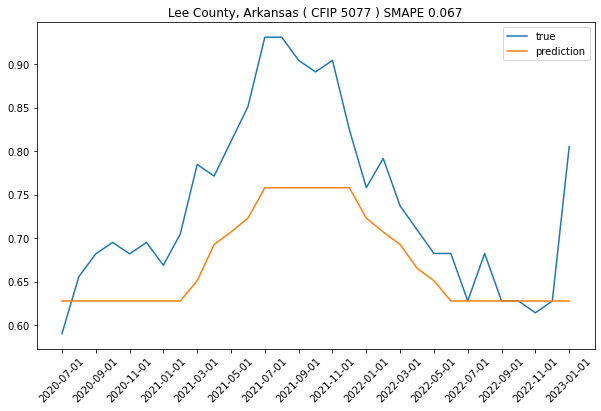

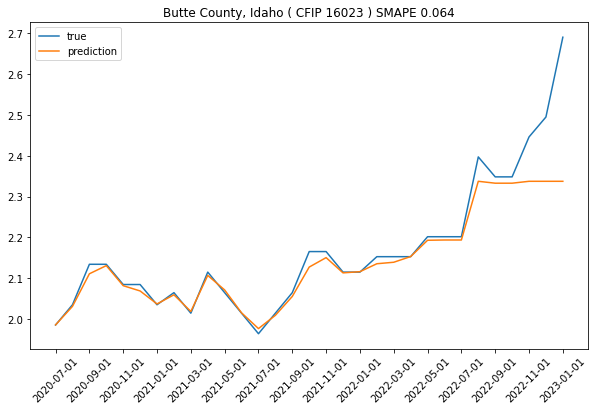

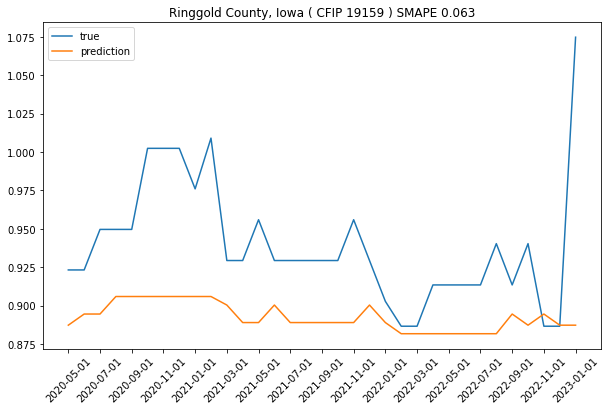

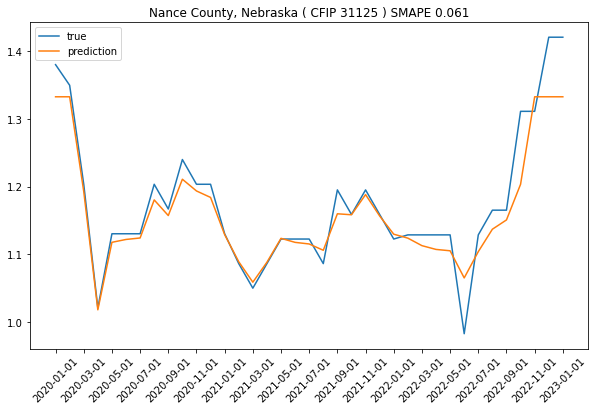

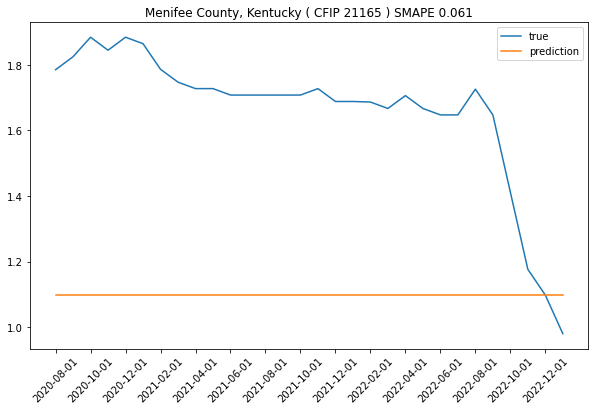

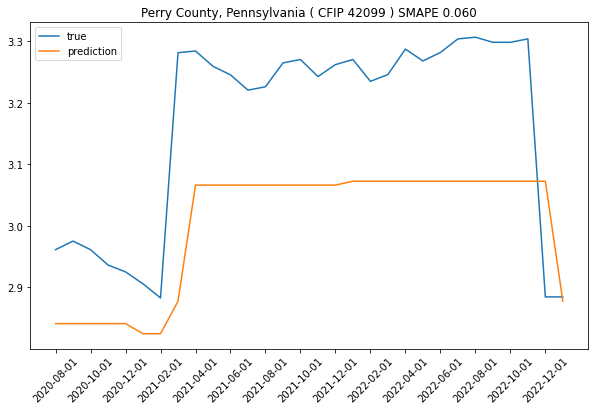

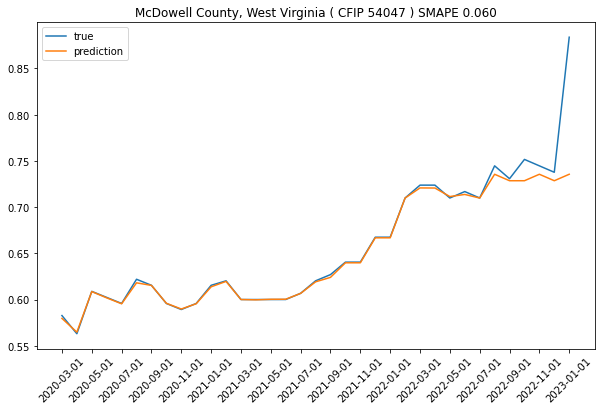

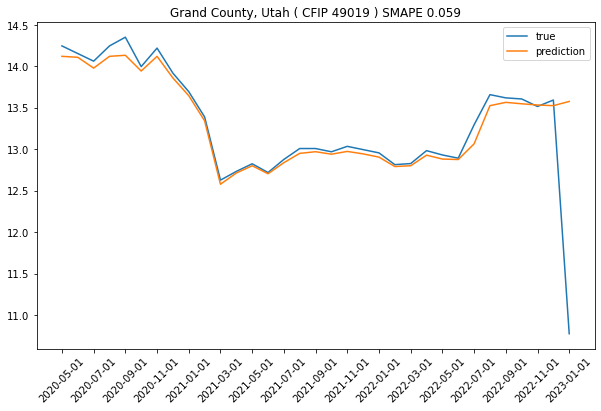

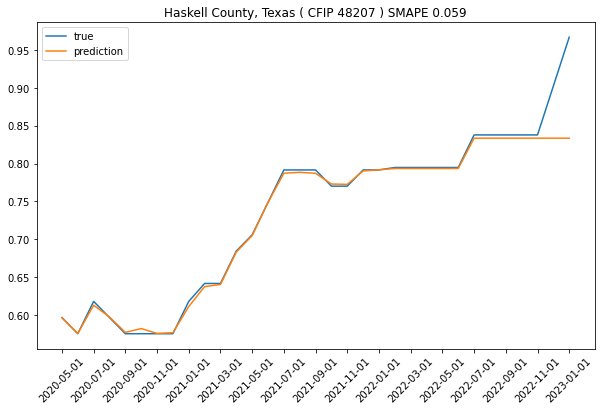

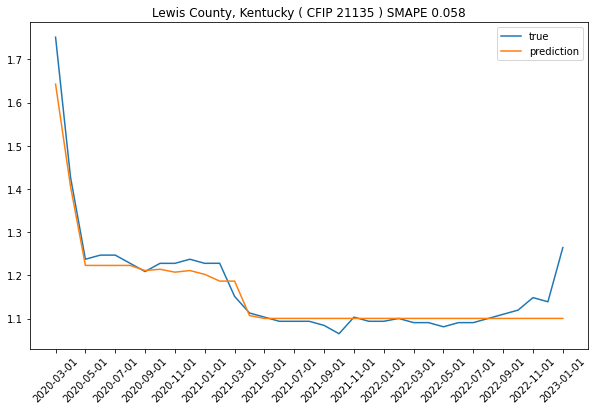

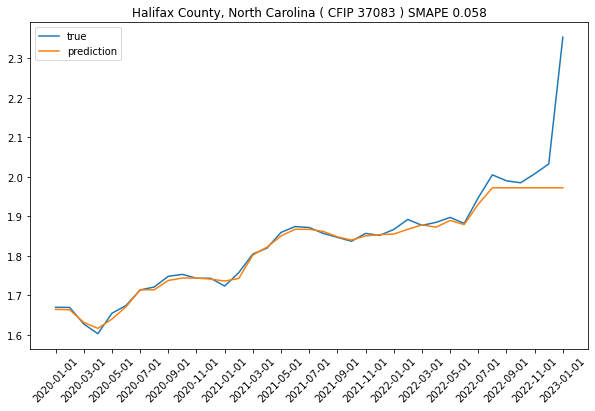

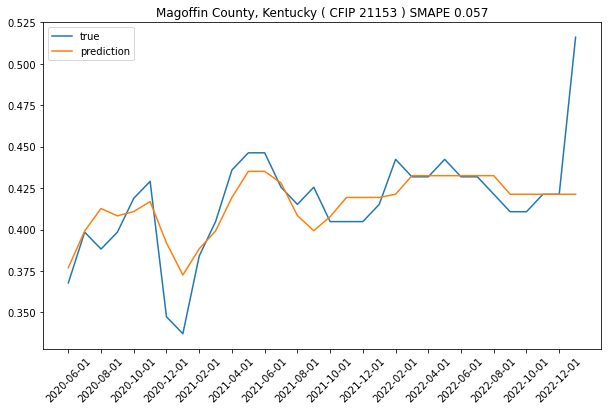

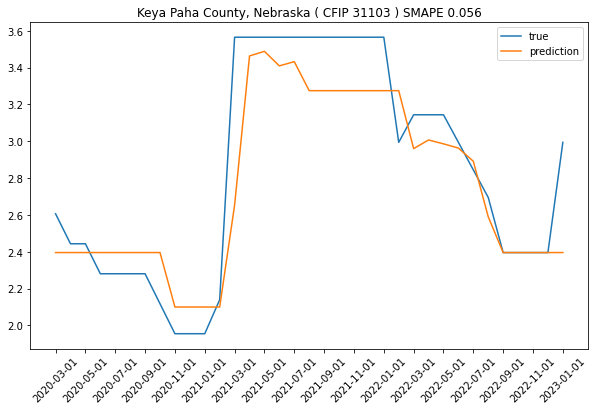

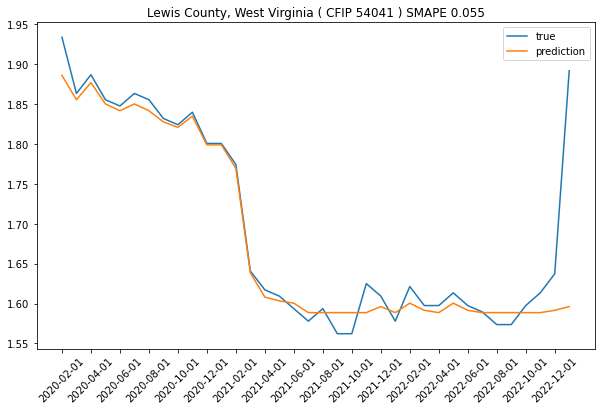

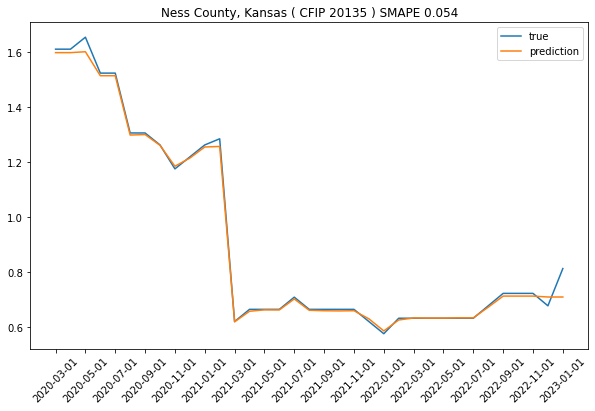

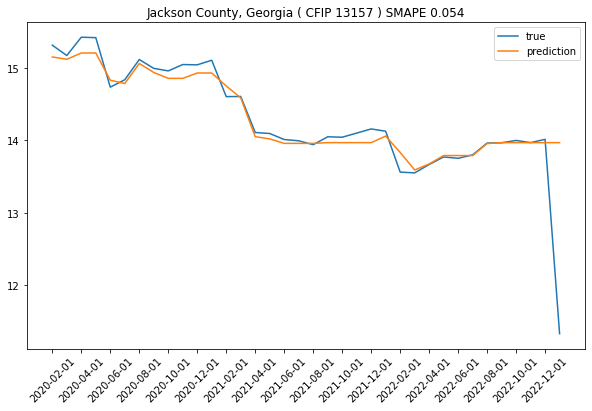

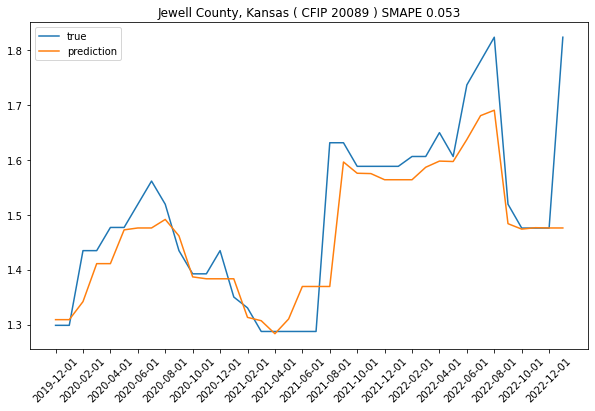

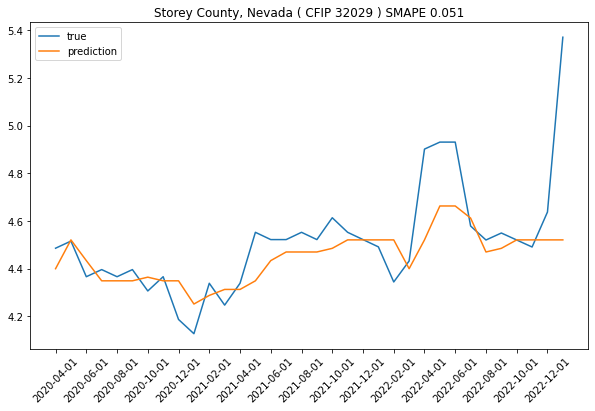

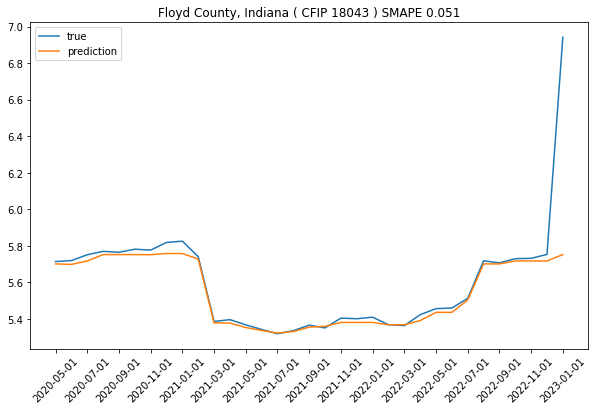

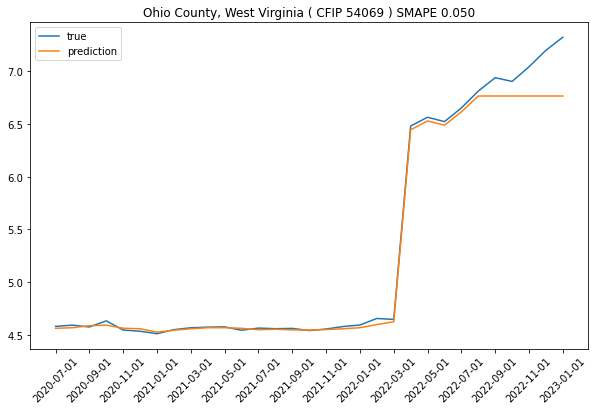

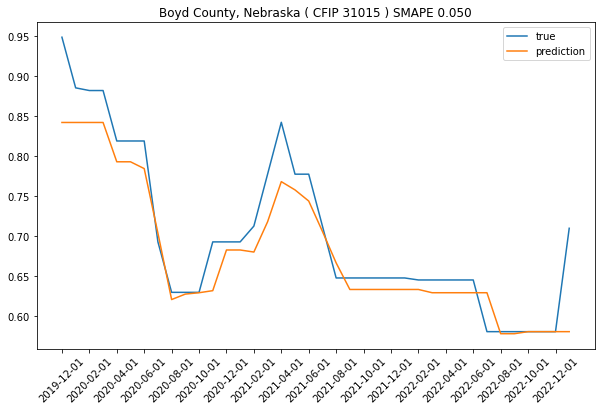

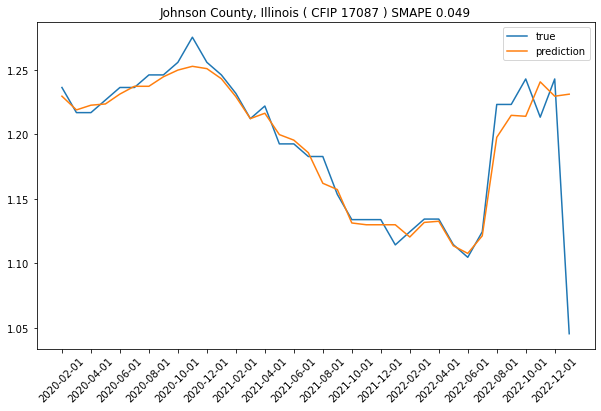

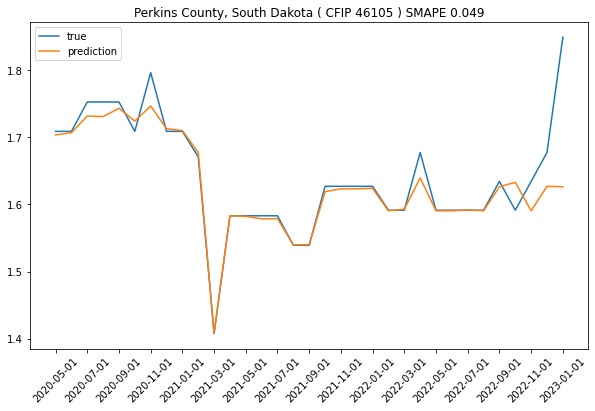

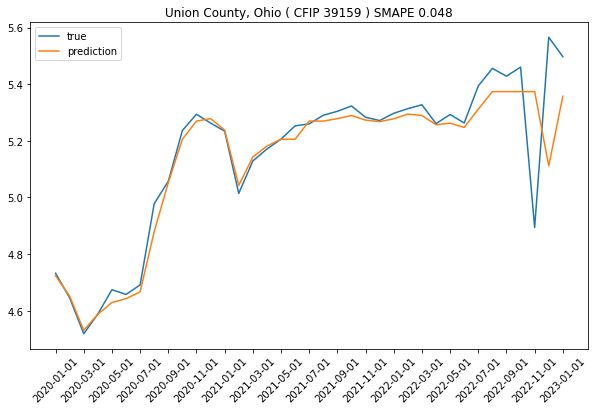

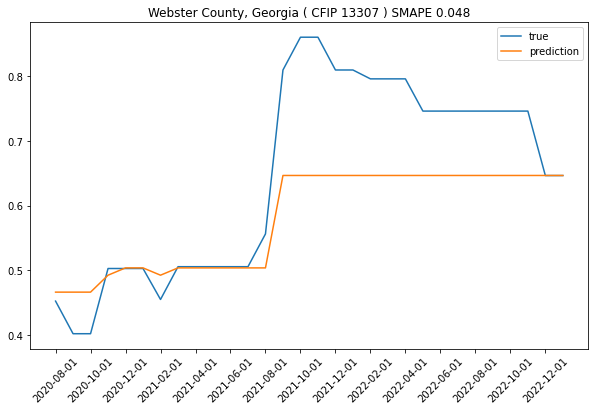

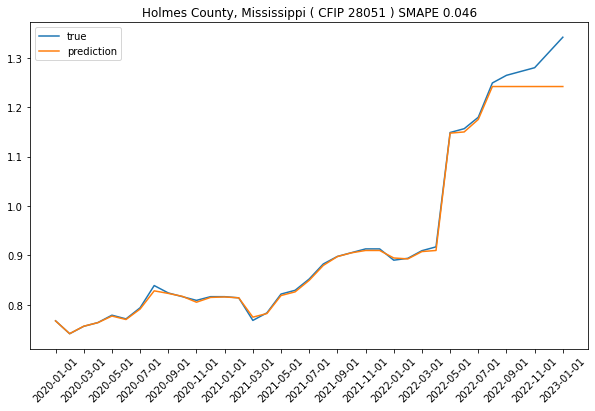

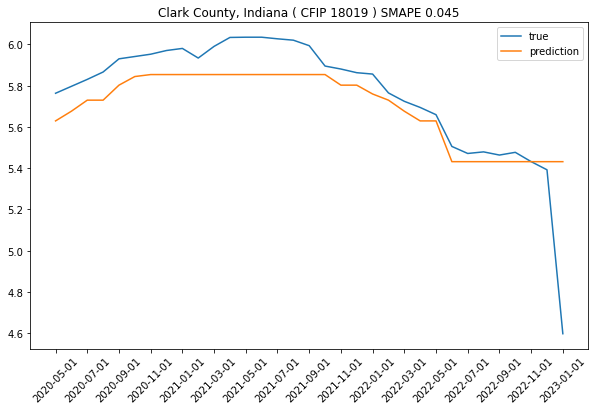

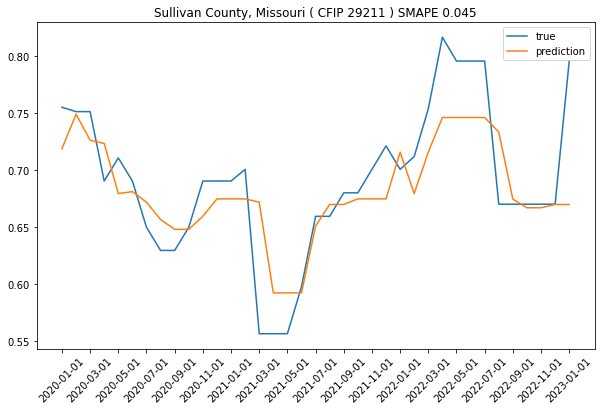

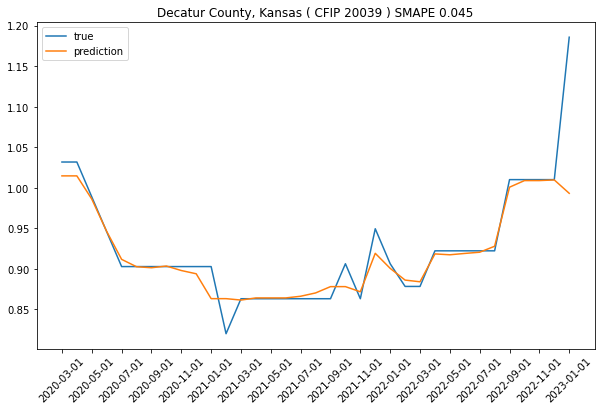

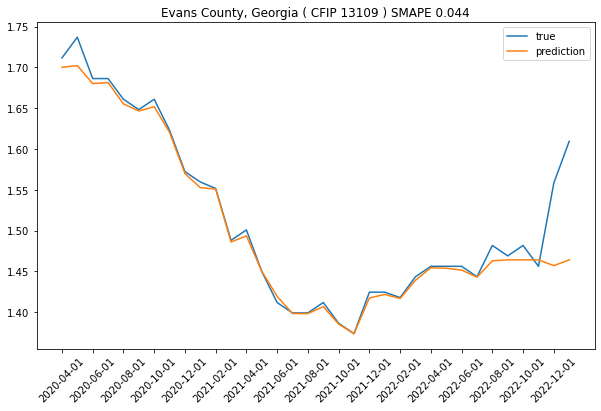

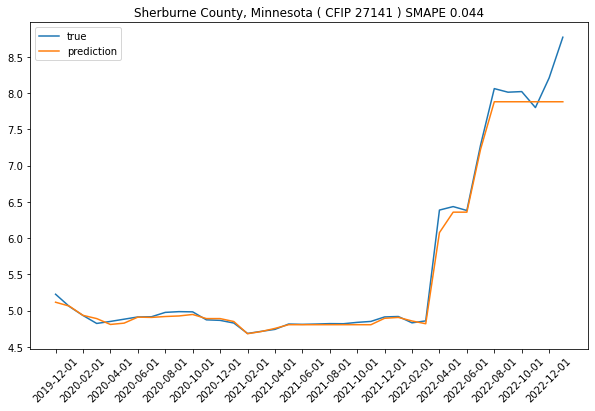

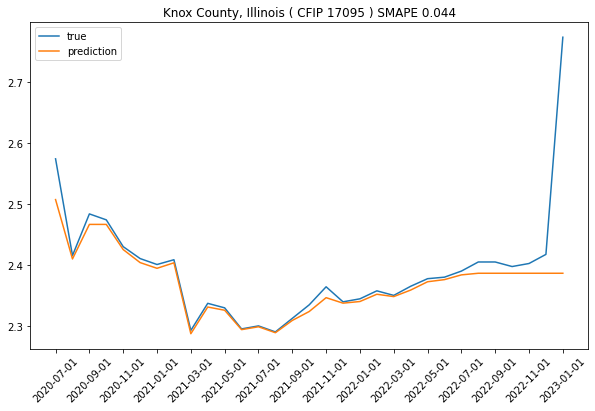

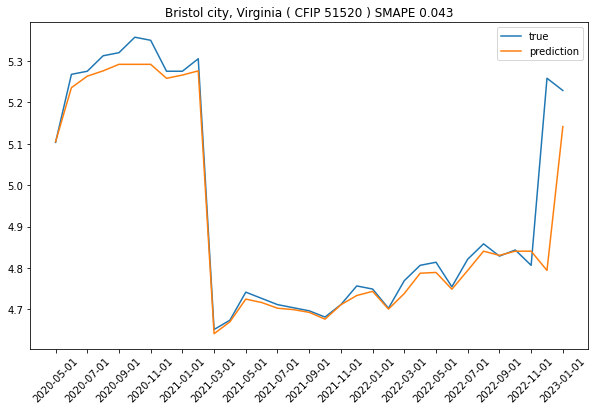

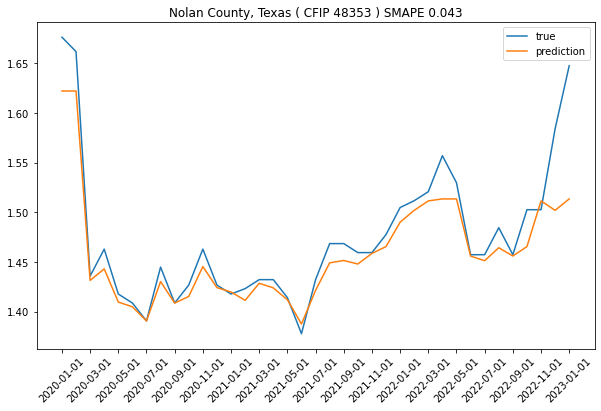

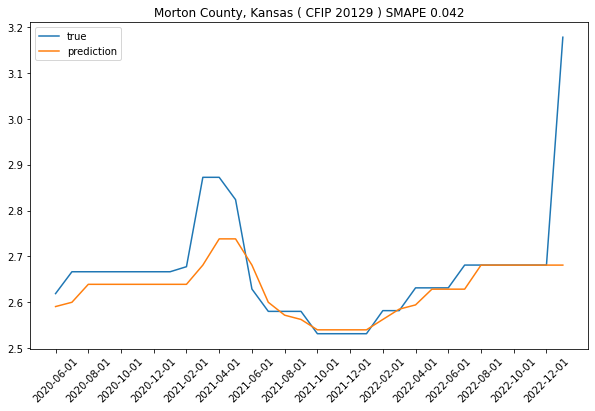

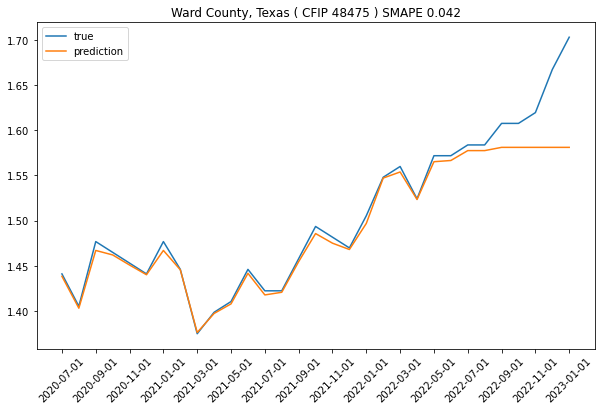

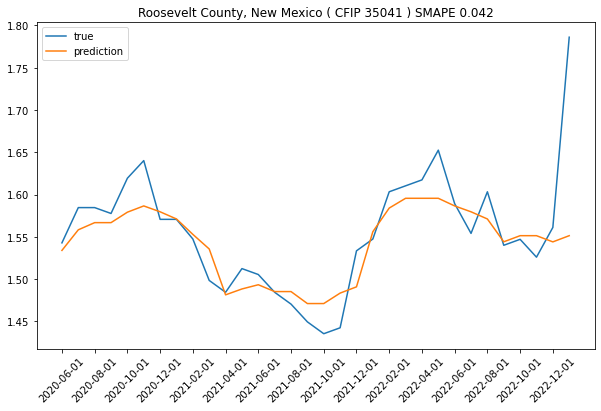

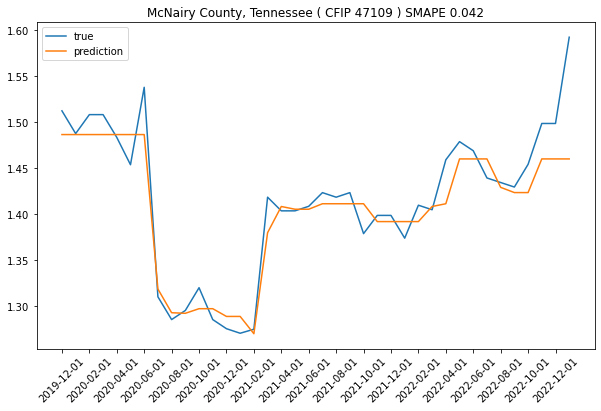

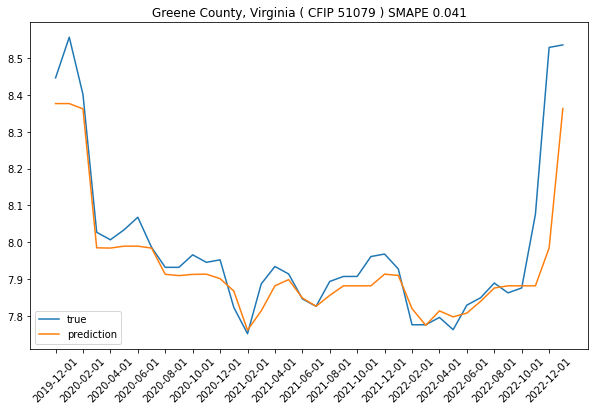

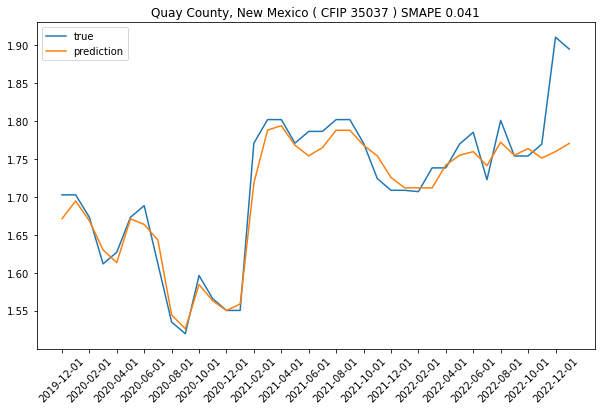

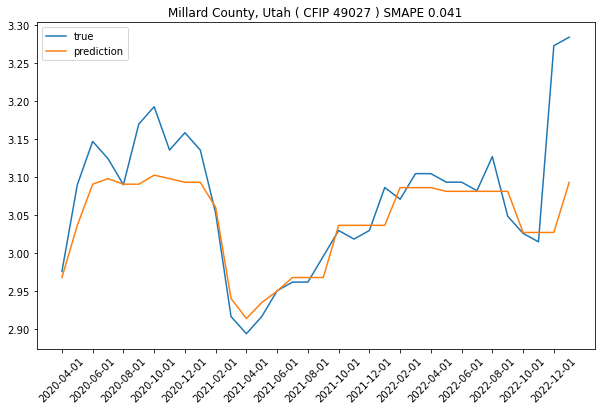

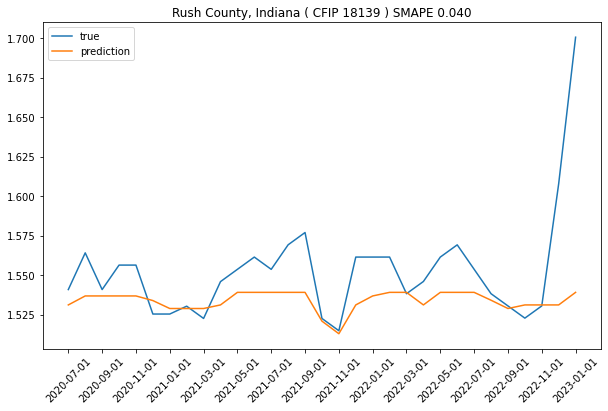

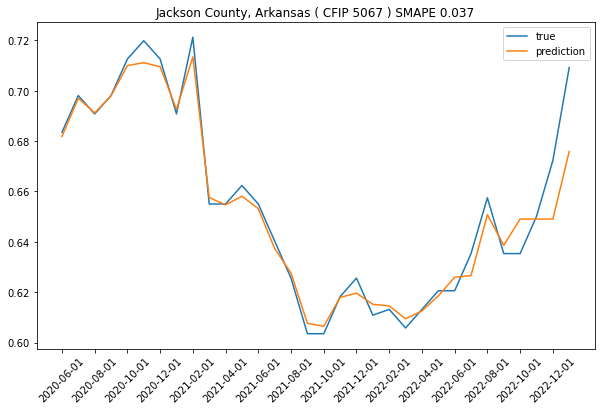

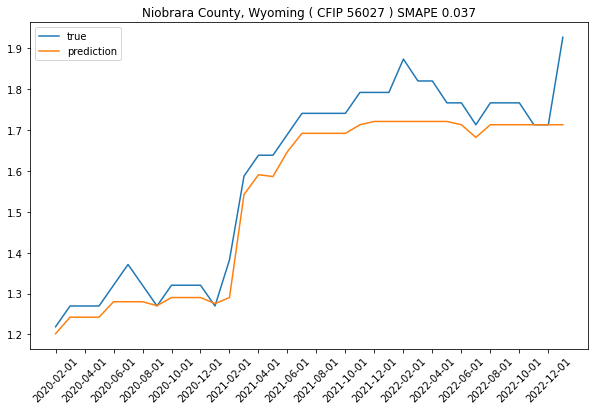

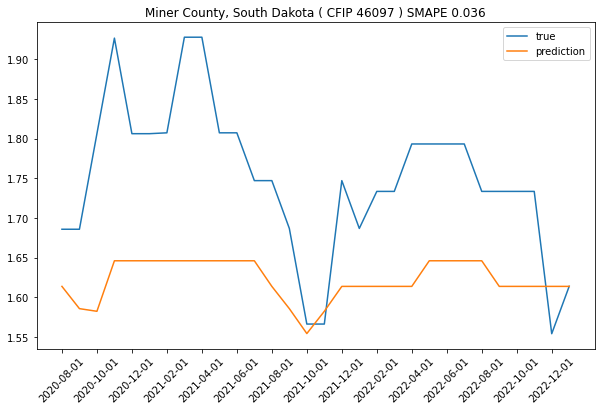

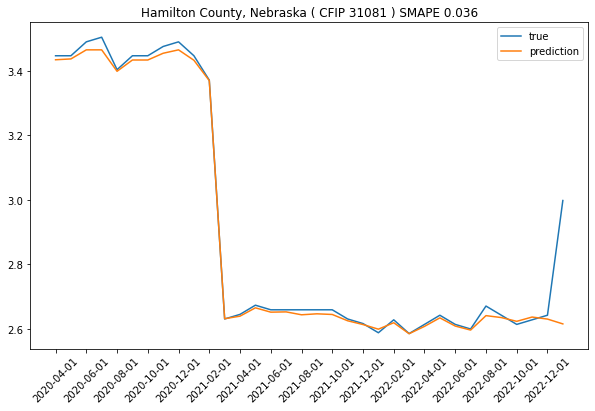

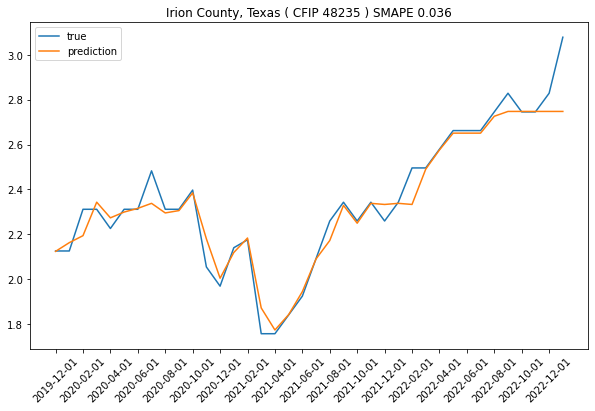

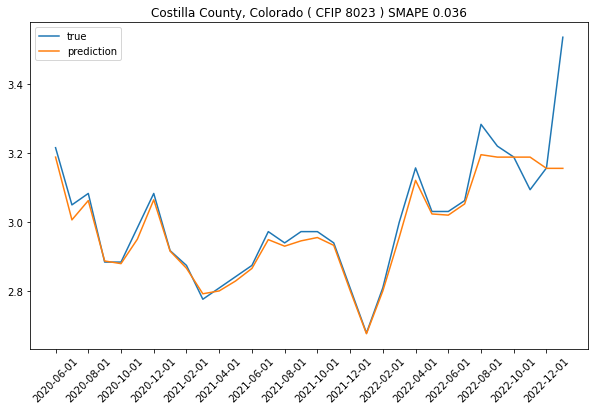

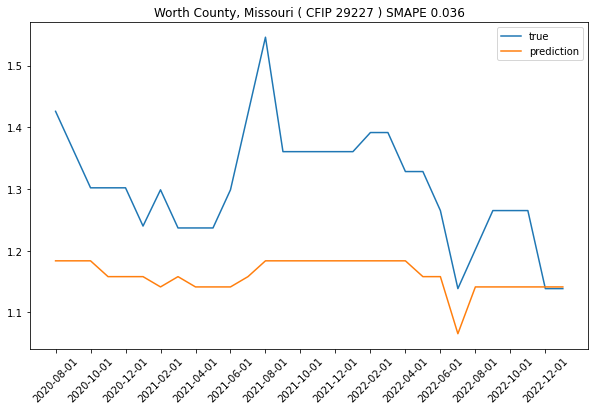

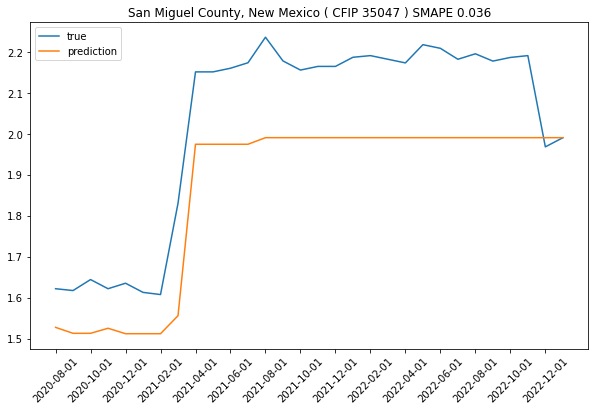

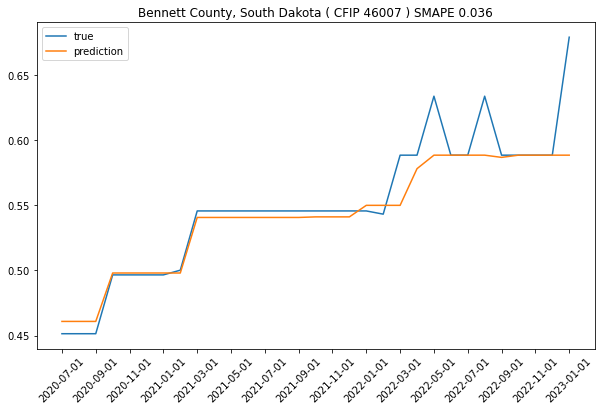

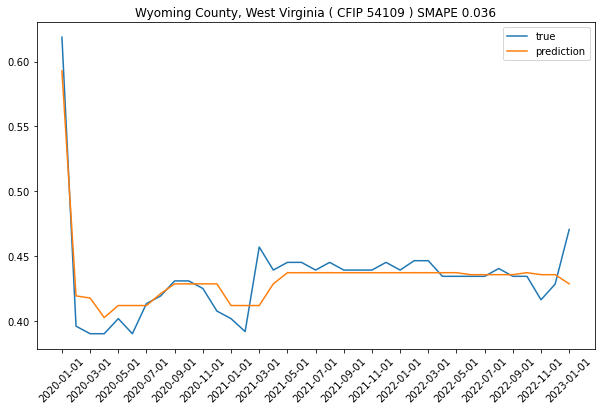

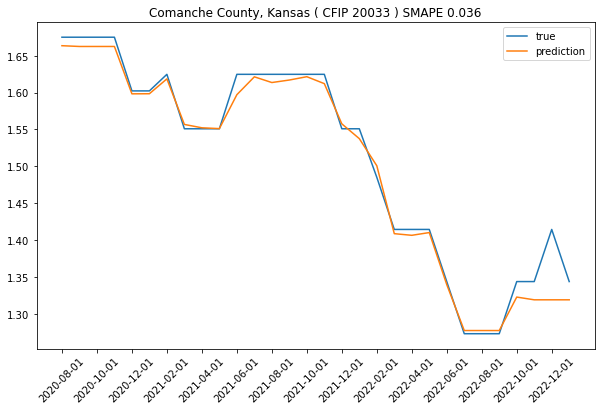

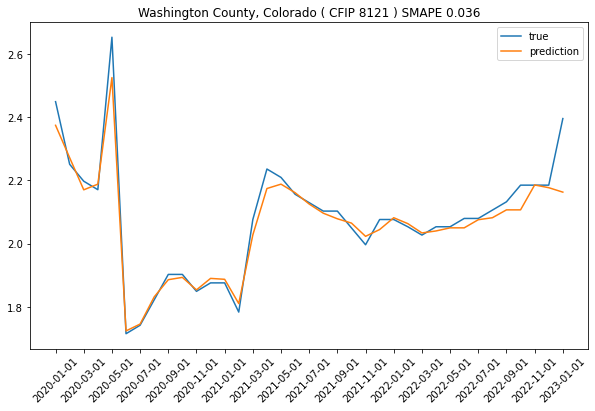

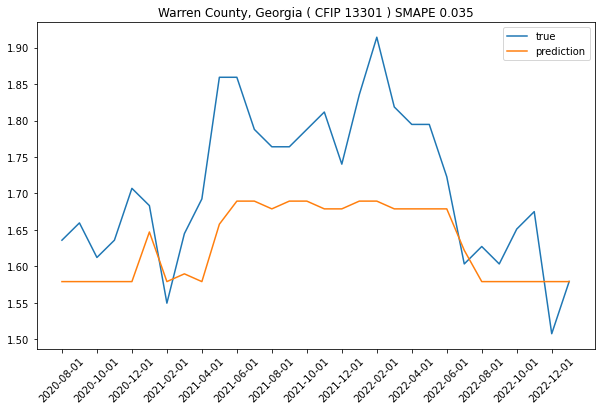

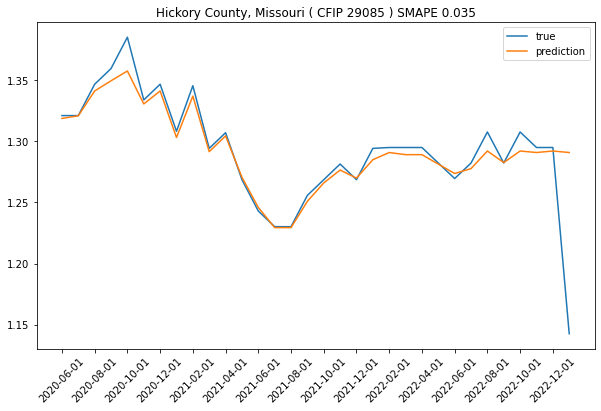

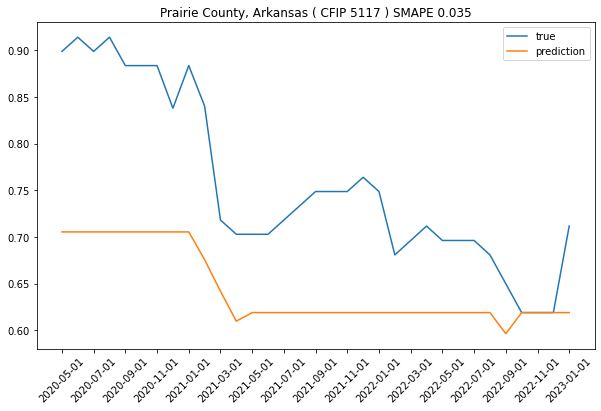

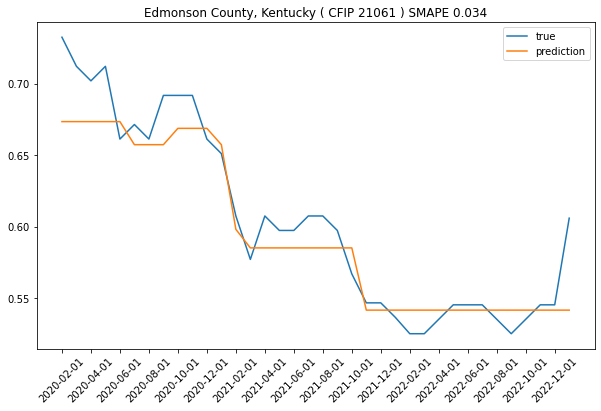

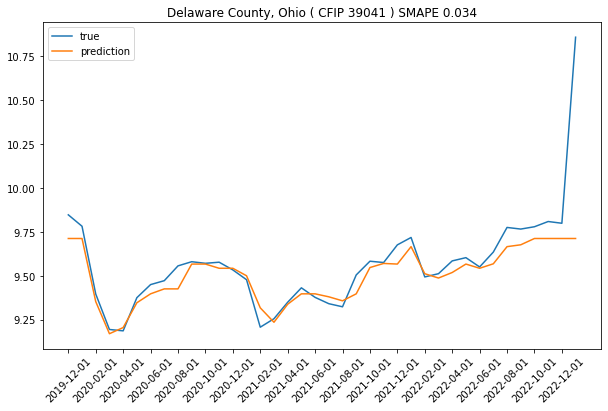

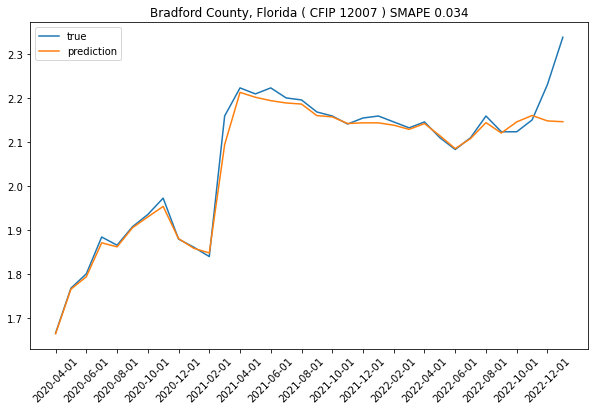

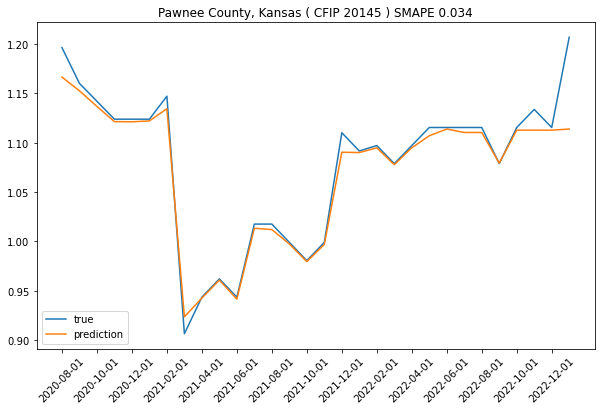

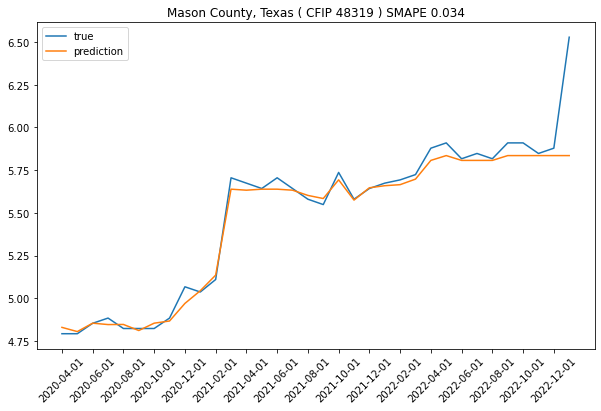

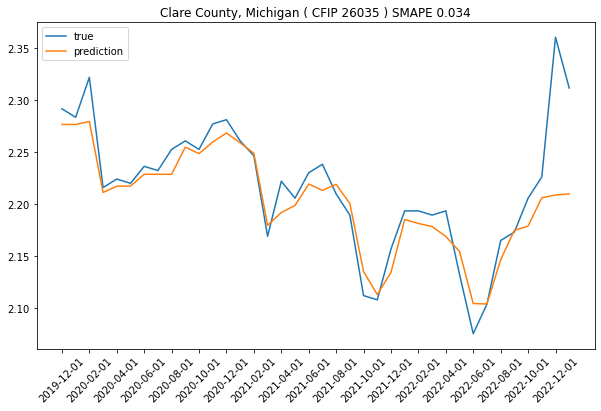

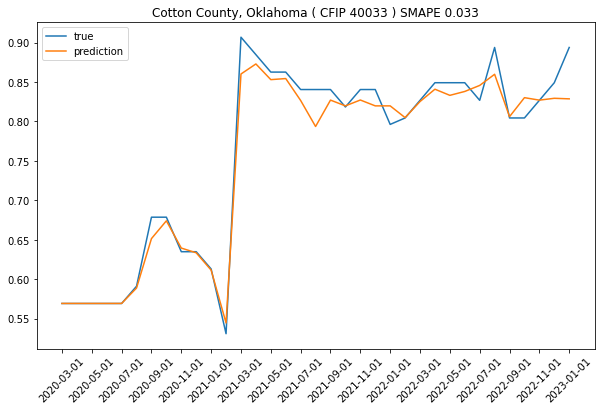

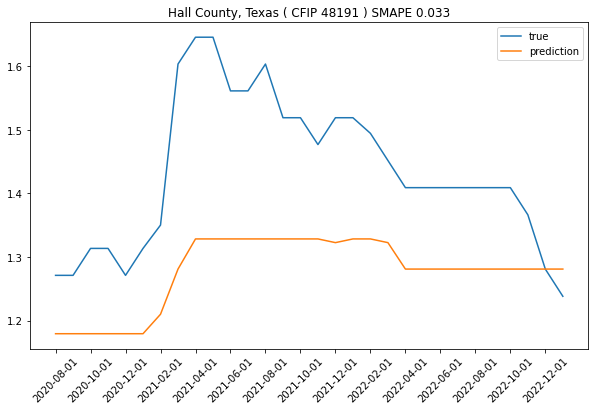

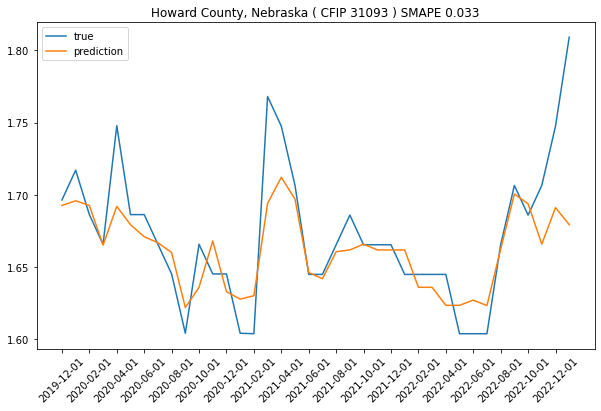

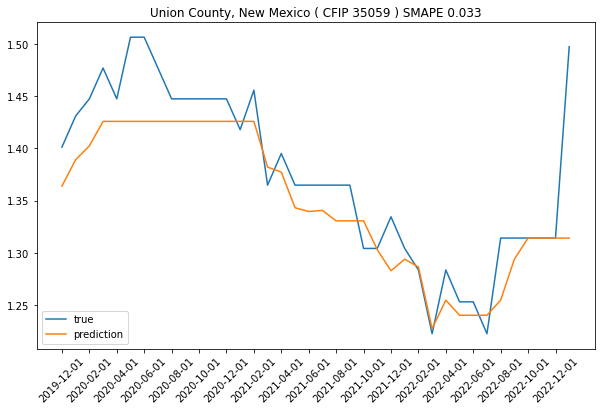

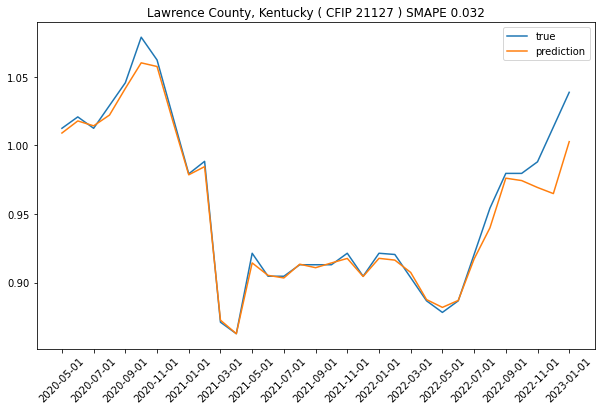

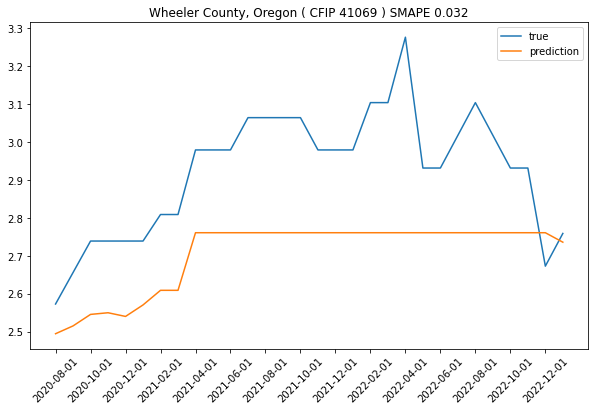

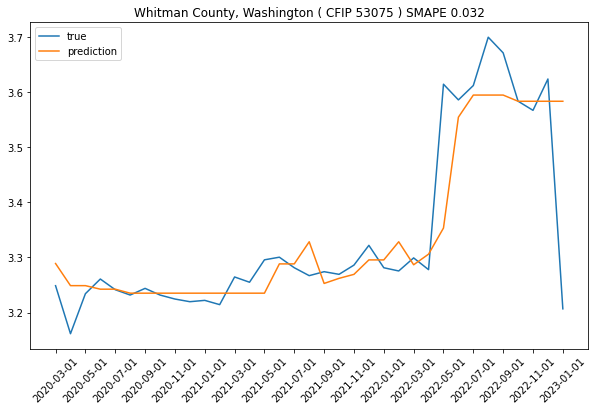

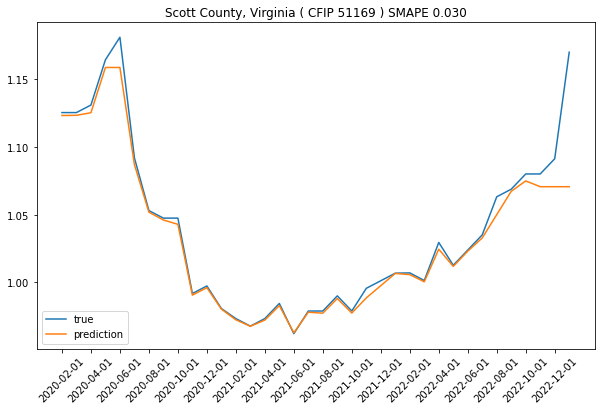

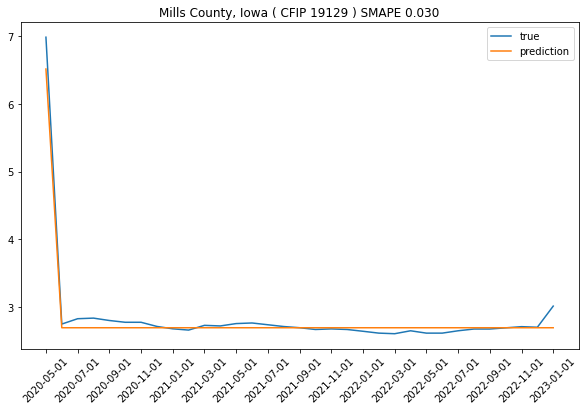

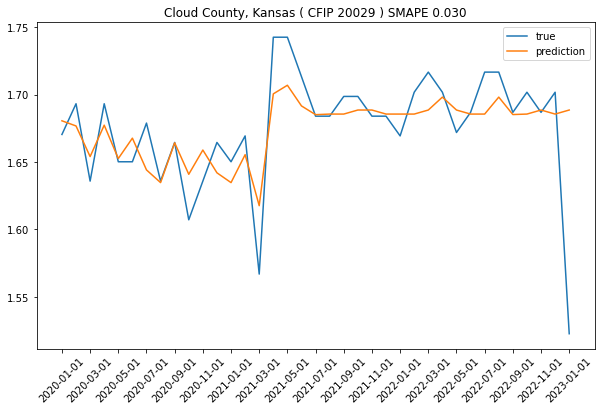

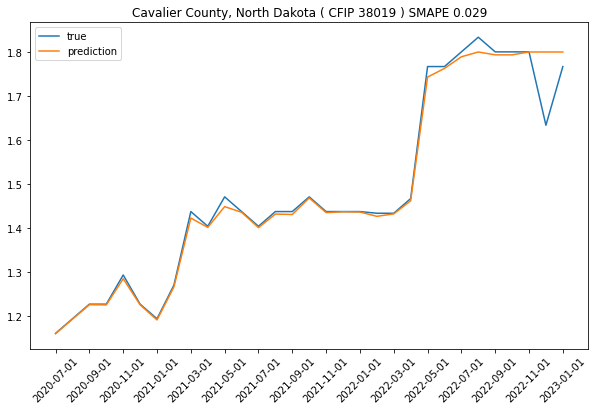

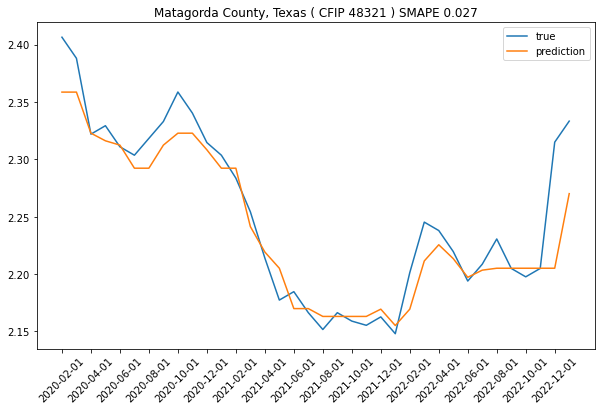

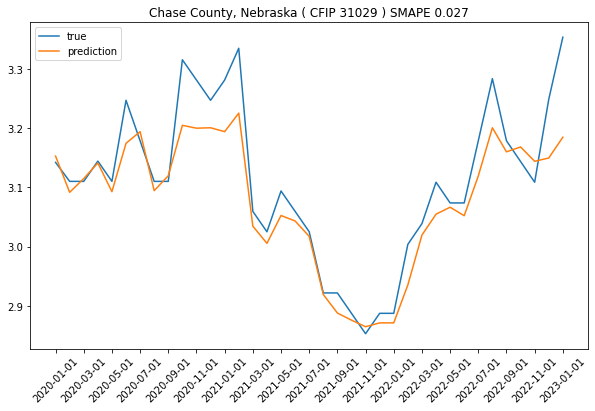

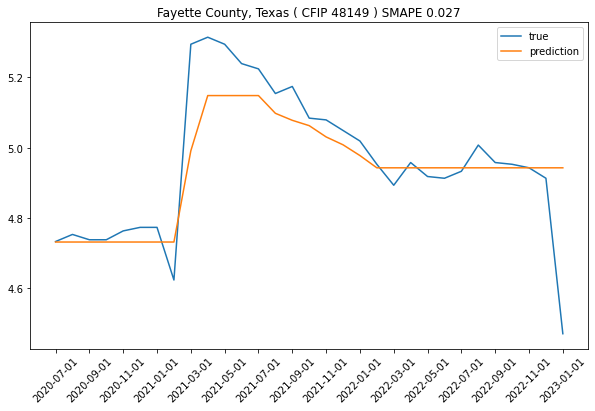

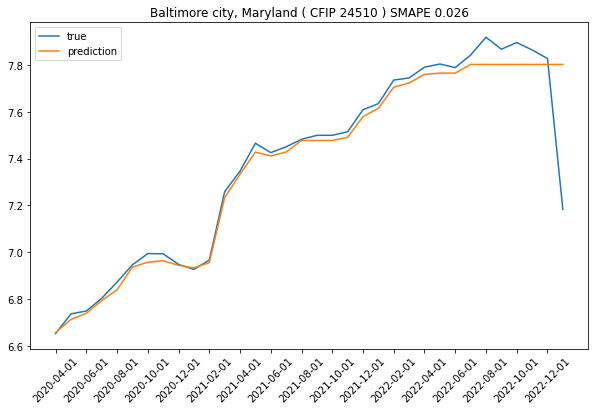

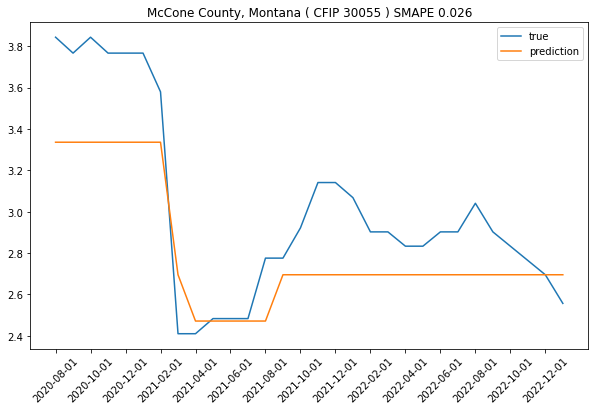

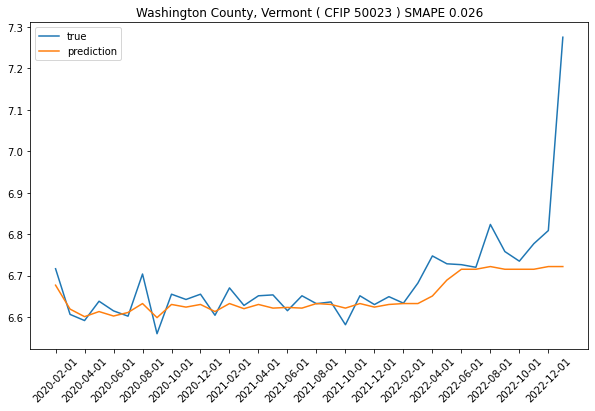

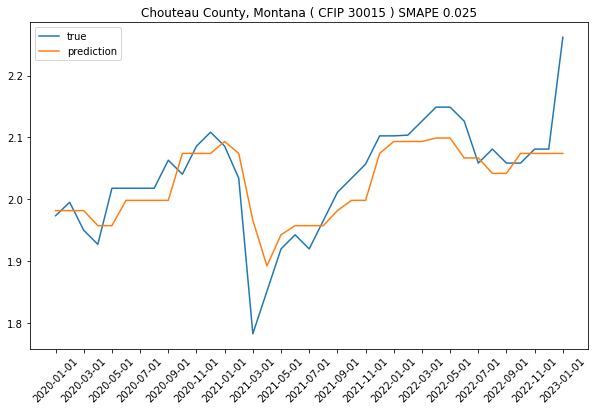

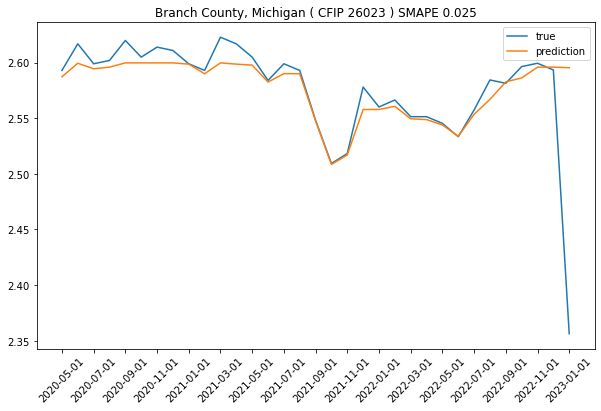

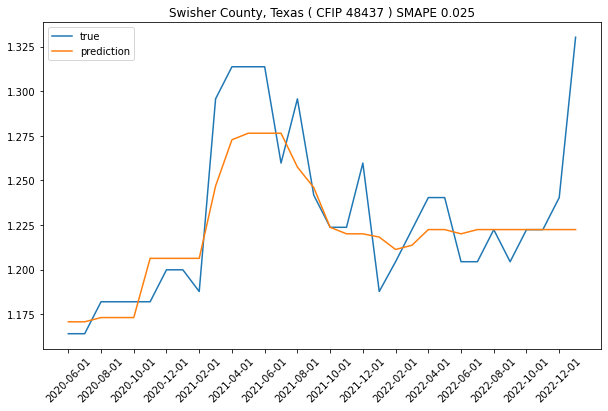

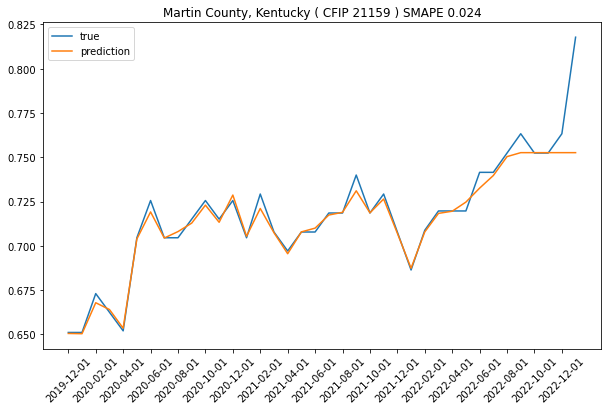

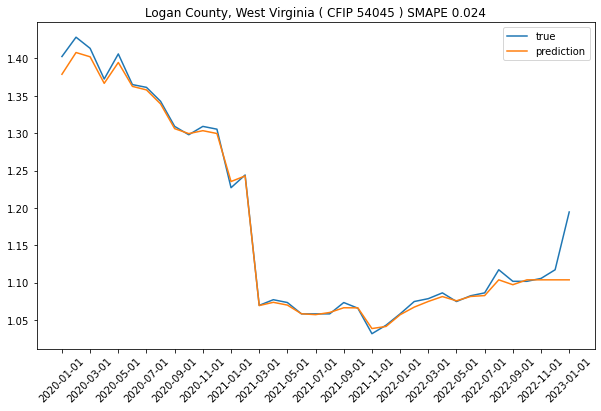

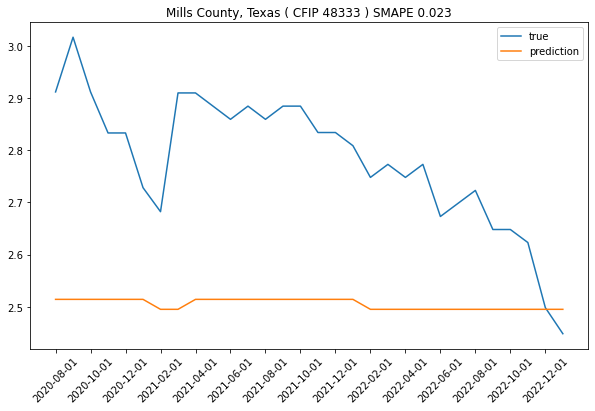

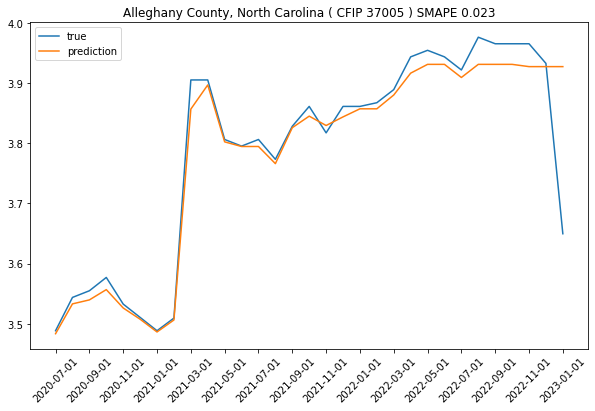

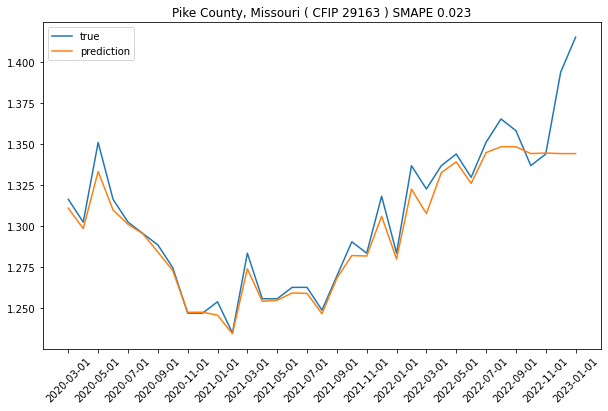

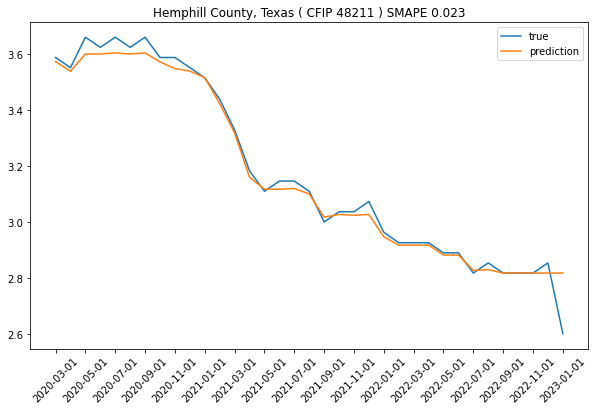

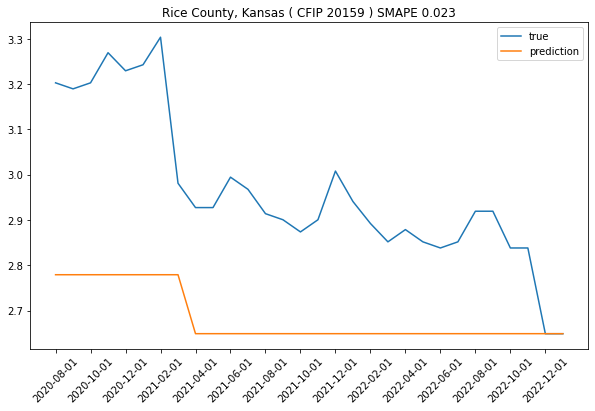

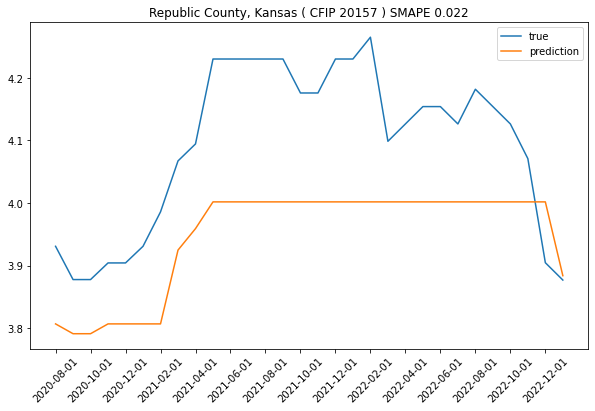

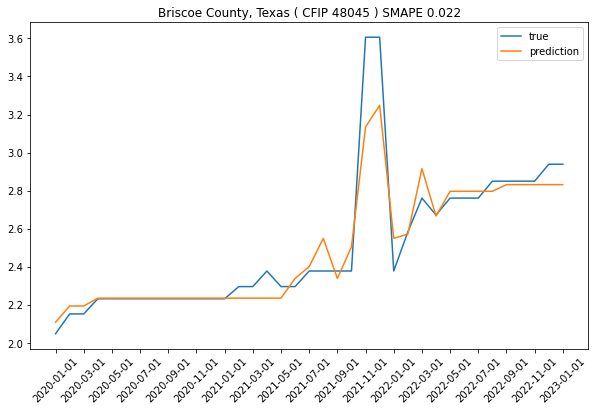

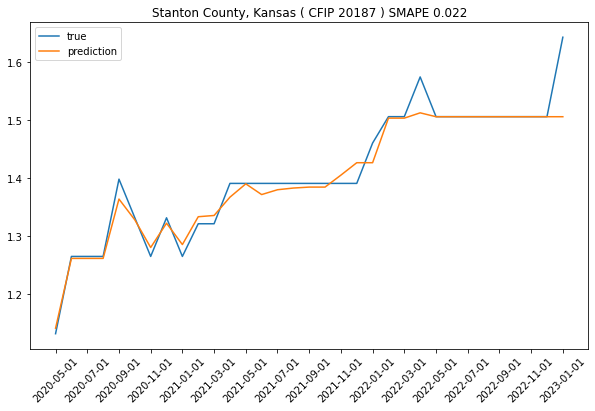

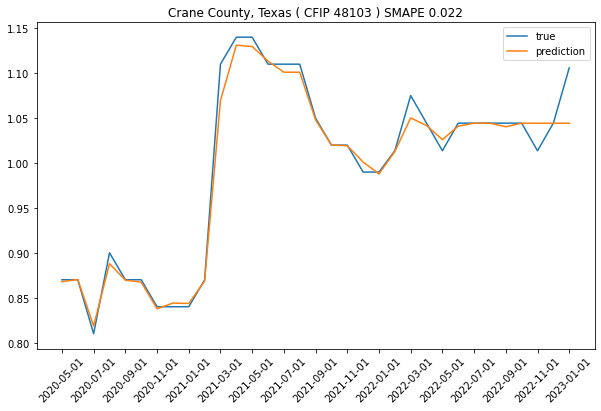

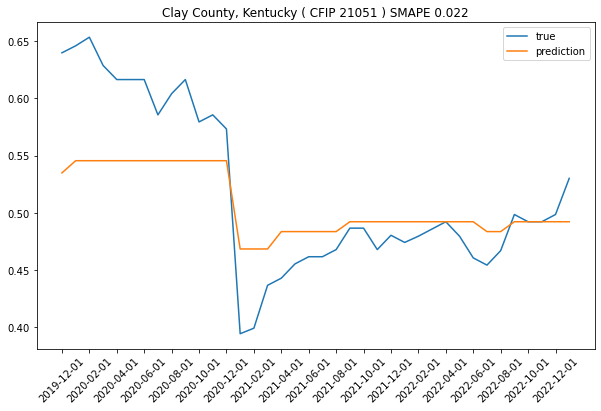

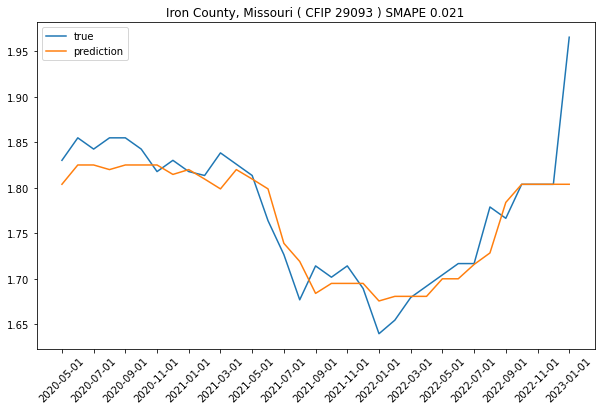

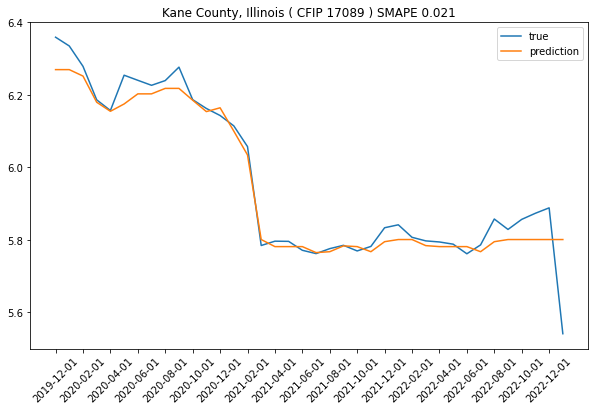

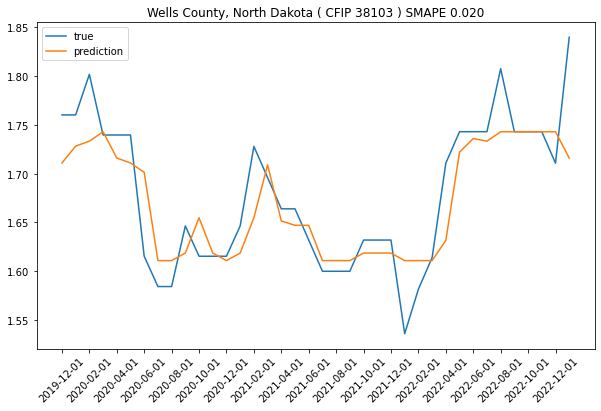

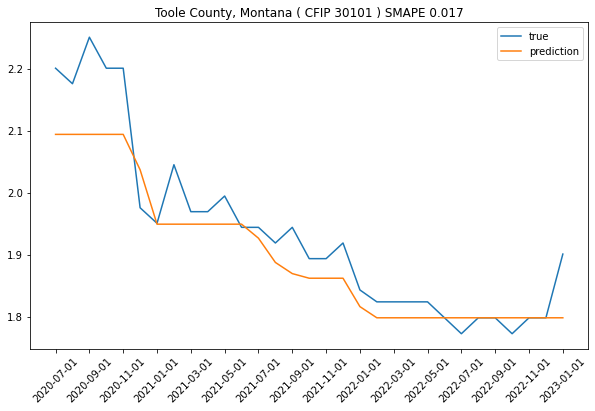

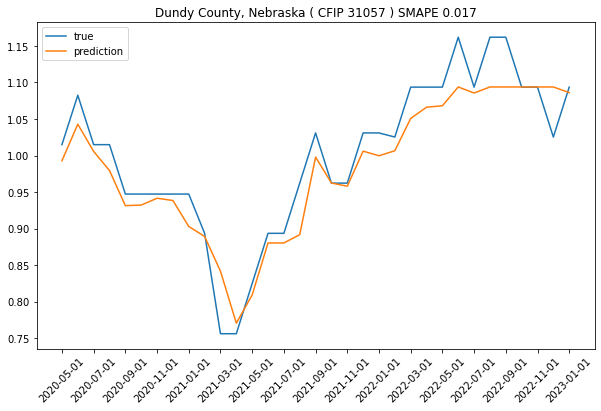

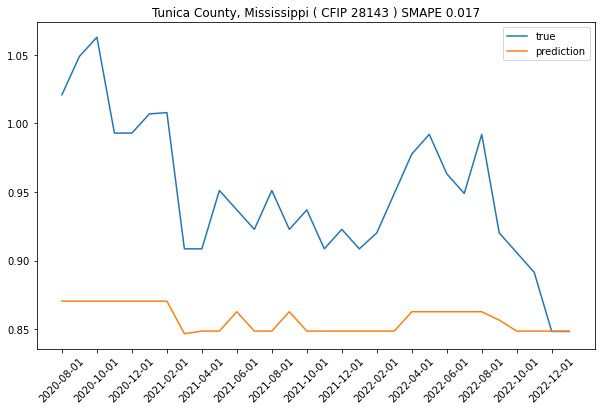

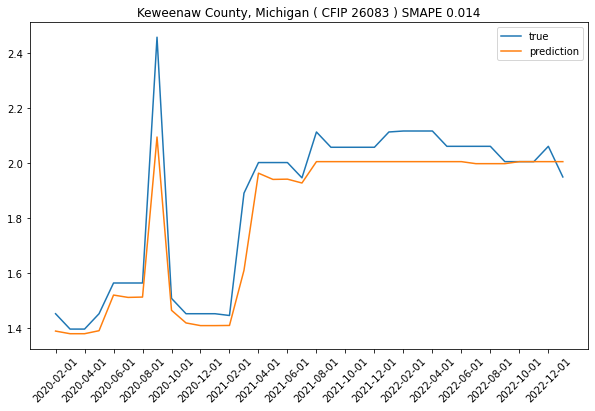

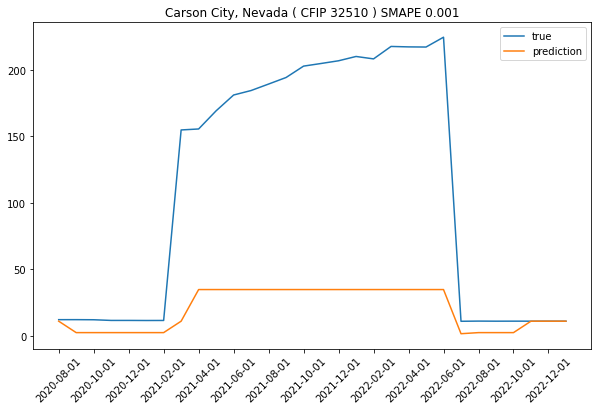

In [370]:

for _, cfip, _, _ in cfips_avail: 
    plt.figure(figsize=(10,6))
    dates = pd.date_range(start='2019-08-01', end='2023-01-01', freq='MS')
    dates = [date.strftime('%Y-%m-%d') for date in dates]
    dates = dates[-len(results2[cfip]["true"]):]
    location = mbd_data[mbd_data.cfips == int(cfip)].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == int(cfip)].state.iloc[0]
    plt.plot(results2[cfip]["true"],label="true")
    plt.plot(results2[cfip]["prediction"],label="prediction")
    plt.legend()
    plt.title(location + " ( CFIP " + cfip + " ) " + f"SMAPE %0.3f"%(results2[cfip]["smape"]))
    ticks = list(range(len(dates)))
    plt.xticks(ticks[::2],dates[::2],rotation=45)
    plt.show()

In [371]:
df = pd.DataFrame(columns=["Cluster","Size","cfip","Train SMAPE","Validation SMAPE","Train RMSE", "Validation RMSE"])
for cluster_id in results:
    for cfip in results[cluster_id]:
        df.loc[len(df.index)] = [cluster_id, len(results[cluster_id]), cfip, results[cluster_id][cfip]["train_smape"], results[cluster_id][cfip]["val_smape"], results[cluster_id][cfip]["train_rmse"], results[cluster_id][cfip]["val_rmse"]]

In [372]:
df[df["Validation SMAPE"] > 0.05]

Cluster Size   cfip  Train SMAPE  Validation SMAPE  Train RMSE  \
0        -1   26   8033     0.097011          0.103729    0.046119   
1        -1   26  13157     0.043991          0.053534    0.113588   
2        -1   26  15005     0.949153          0.228695    3.927664   
4        -1   26  18157     0.101168          0.082155    0.036030   
6        -1   26  20135     0.378591          0.053544    0.012547   
..      ...  ...    ...          ...               ...         ...   
141       0  133  48263     0.114625          0.092569    0.065942   
142       0  133  48311     0.069475          0.074603    0.102948   
153       0  133  54041     0.076224          0.054660    0.015279   
155       0  133  54047     0.086742          0.059771    0.002288   
157       0  133  56011     0.031267          0.098696    0.032601   

     Validation RMSE  
0           0.517590  
1           1.320243  
2           0.187701  
4           0.343067  
6           0.054556  
..               ...  
141         0.199499  
142         0.197664  
153         0.149990  
155         0.075320  
157         0.501272  

[77 rows x 7 columns]

In [373]:
df2 = pd.DataFrame(columns=["Cluster","Size", "Train SMAPE","Validation SMAPE","Train RMSE", "Validation RMSE"])
for cluster_id in ["0","-1"]:
    arr = []
    count = 0 
    for cfip in results[cluster_id]:
        if results[cluster_id][cfip]["val_smape"] > 0.05 : 
            count += 1
            arr.append([results[cluster_id][cfip]["train_smape"], results[cluster_id][cfip]["val_smape"], results[cluster_id][cfip]["train_rmse"], results[cluster_id][cfip]["val_rmse"]])
    arr = np.array(arr)
    arr = np.mean(arr,axis=0)
    df2.loc[len(df2.index)] = [cluster_id,count, arr[0], arr[1], arr[2], arr[3] ]

In [374]:
df2

Cluster Size  Train SMAPE  Validation SMAPE  Train RMSE  Validation RMSE
0       0   61     0.130209          0.133760    0.049836         0.447758
1      -1   16     0.280142          0.194753    0.638444         7.542580

In [375]:
tmp = df[ df["Validation SMAPE"] > 0.05 ][["Cluster","cfip"]].values 
results3 = {}
for cluster_id, cfip in tmp: 
    if cluster_id in results3: 
        results3[cluster_id].append(cfip)
    else: 
        results3[cluster_id] = [cfip]

In [376]:
json.dump(results3,open("./outputs/clusters_xgboost.json","w"))